### 전체 Adult dataset 분석

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# JSON 데이터 로드
file_path = '../data/adult_train_retain.json'

# JSON 파일 읽기
with open(file_path, 'r') as file:
    data = json.load(file)

# 데이터를 Pandas DataFrame으로 변환
df = pd.DataFrame(data)

# 데이터 확인
print("데이터 샘플:")
print(df.head())
print("\n데이터 정보:")
print(df.info())
print("\n기술 통계:")
print(df.describe())


데이터 샘플:
   age  capital_gain  capital_loss   education  final_weight  \
0   43           0.0           0.0  Assoc-acdm         34278   
1   23           0.0           0.0     5th-6th        244698   
2   39           0.0           0.0  Assoc-acdm        118286   
3   35           0.0           0.0     HS-grad        126675   
4   66           0.0           0.0   Bachelors         28367   

   hours_worked_per_week      marital_status native_country       occupation  \
0                     35  Married-civ-spouse  United-States            Sales   
1                     35       Never-married         Mexico  Farming-fishing   
2                     40  Married-civ-spouse  United-States            Sales   
3                     46            Divorced              ?     Craft-repair   
4                     99  Married-civ-spouse  United-States  Priv-house-serv   

    race    relationship  gender workclass  over_threshold  
0  White         Husband       0   Private               0  
1  W

In [3]:
# gender와 over_threshold를 범주형 데이터로 변환
df['gender'] = df['gender'].apply(lambda x: 'Male' if x == 0 else 'Female')

df['over_threshold'] = df['over_threshold'].apply(lambda x: 'Below Threshold' if x == 0 else 'Above Threshold')

# 데이터 타입을 범주형으로 명시적으로 설정
df['gender'] = df['gender'].astype('object')
df['over_threshold'] = df['over_threshold'].astype('object')

# 변환 후 데이터 확인
print("변환된 데이터 샘플:")
print(df[['gender', 'over_threshold']].head())
print("\n변수 데이터 타입:")
print(df.dtypes)


변환된 데이터 샘플:
  gender   over_threshold
0   Male  Below Threshold
1   Male  Below Threshold
2   Male  Below Threshold
3   Male  Below Threshold
4   Male  Below Threshold

변수 데이터 타입:
age                        int64
capital_gain             float64
capital_loss             float64
education                 object
final_weight               int64
hours_worked_per_week      int64
marital_status            object
native_country            object
occupation                object
race                      object
relationship              object
gender                    object
workclass                 object
over_threshold            object
dtype: object


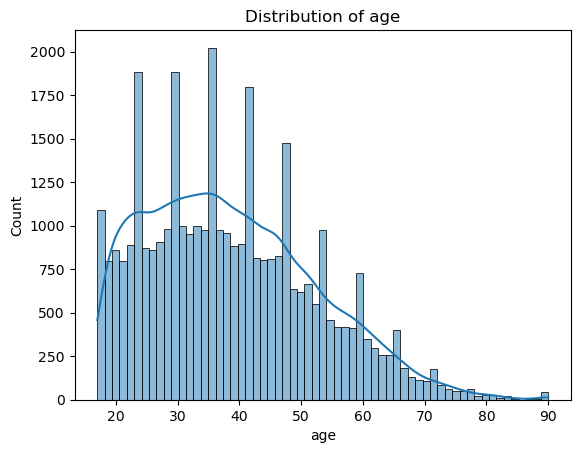

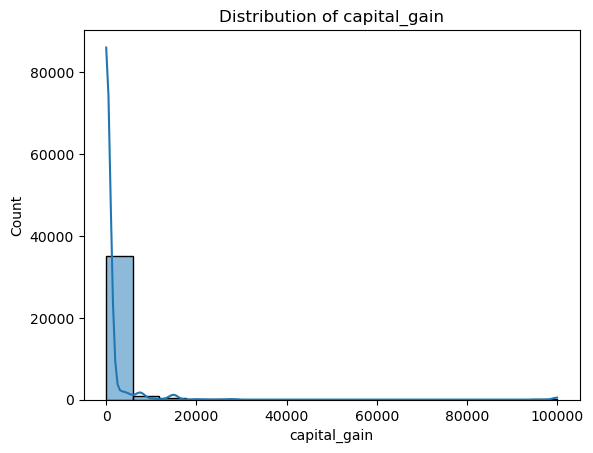

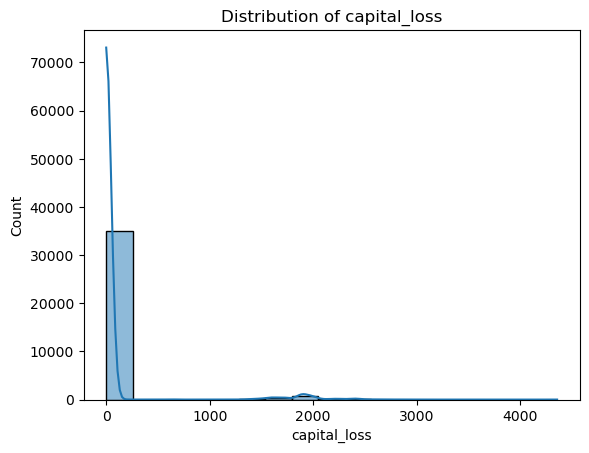

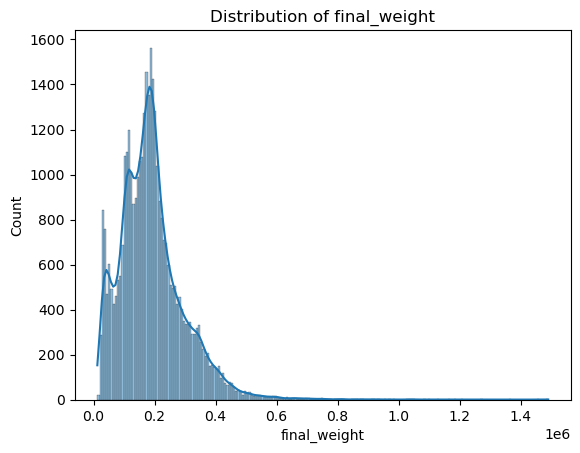

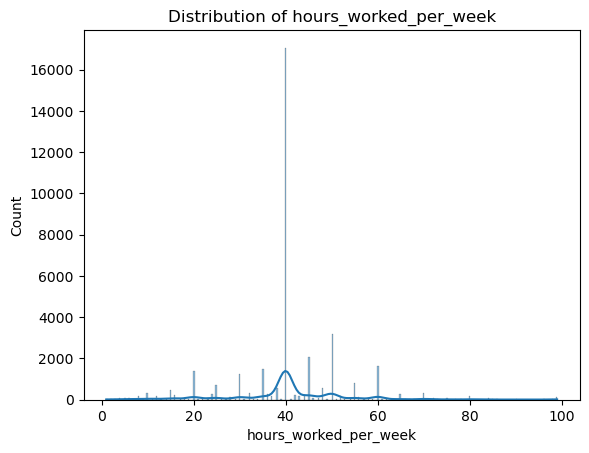

In [4]:
# 수치형 변수 추출
numeric_cols = df.select_dtypes(include='number').columns

# 히스토그램 시각화
for col in numeric_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


capital_gain has 33590 zero values


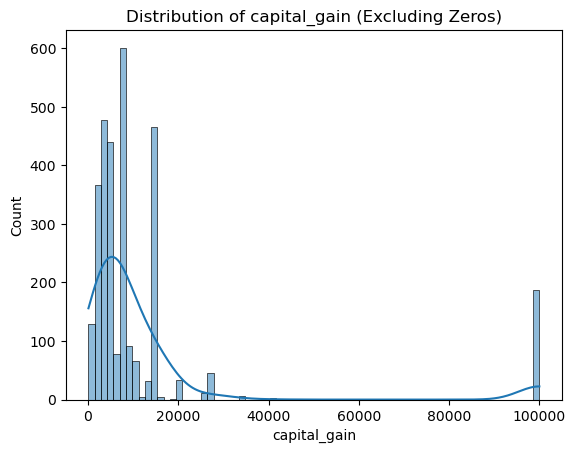

capital_loss has 34955 zero values


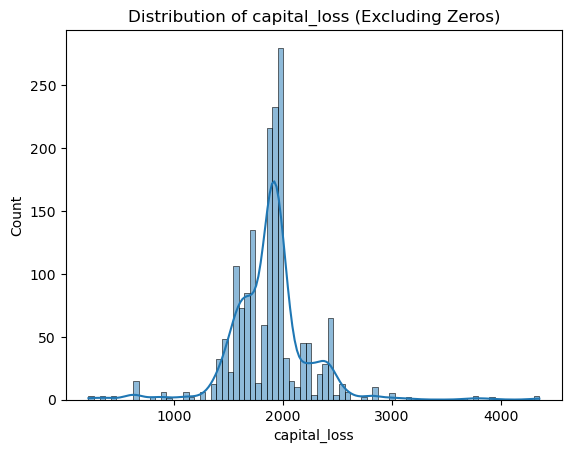

In [5]:
import numpy as np
zero_major_numeric_cols = ['capital_gain', 'capital_loss']

for col in zero_major_numeric_cols:
    # 0과 0이 아닌 데이터 분리
    zero_data = df[df[col] == 0]
    non_zero_data = df[df[col] != 0]

    # 0인 값의 개수 표시
    print(f"{col} has {len(zero_data)} zero values")

    # 0이 아닌 데이터로 히스토그램 그리기
    sns.histplot(non_zero_data[col], kde=True)
    plt.title(f'Distribution of {col} (Excluding Zeros)')
    plt.show()

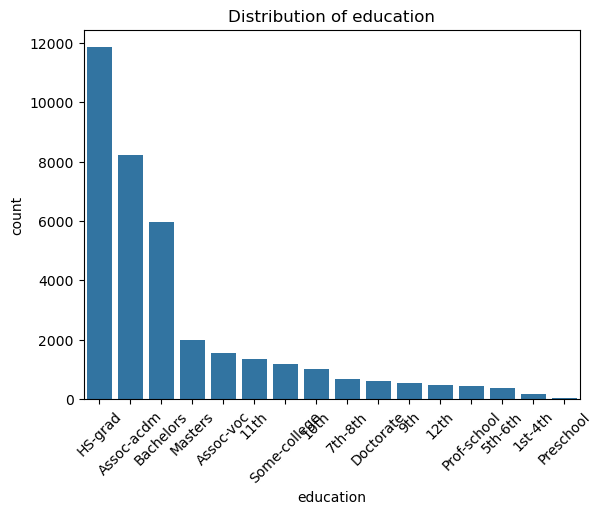

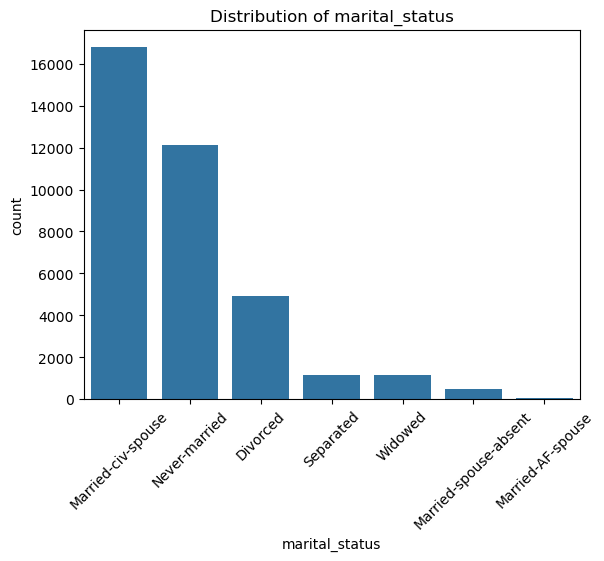

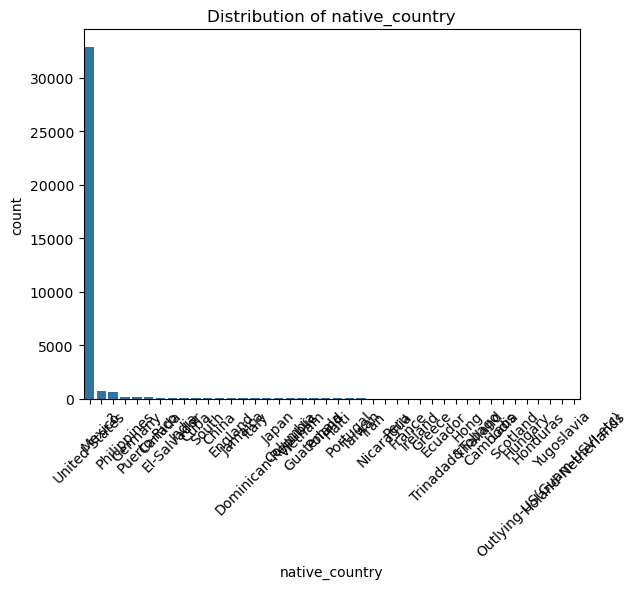

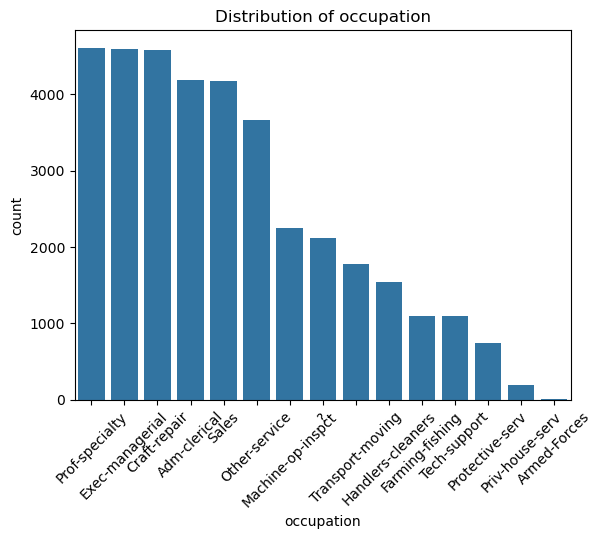

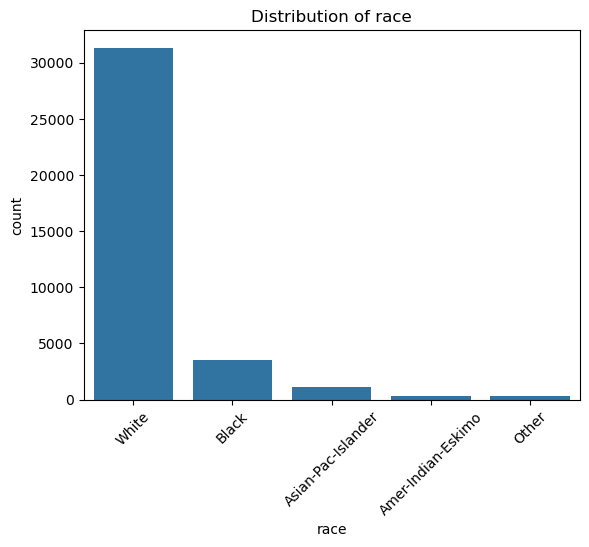

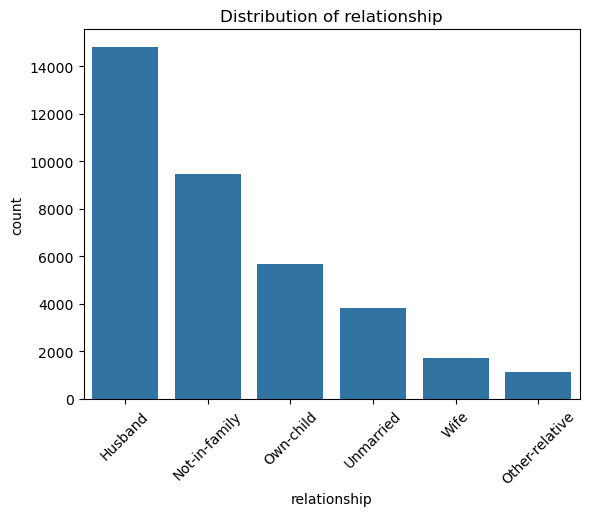

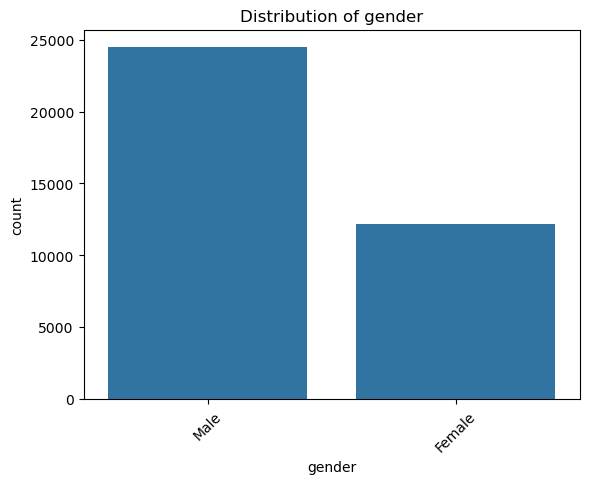

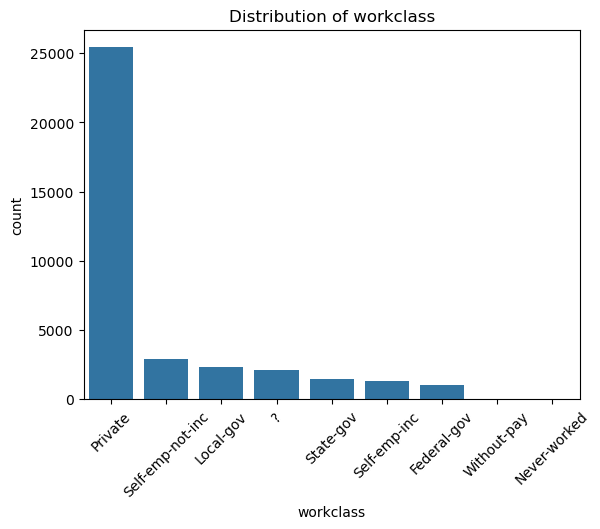

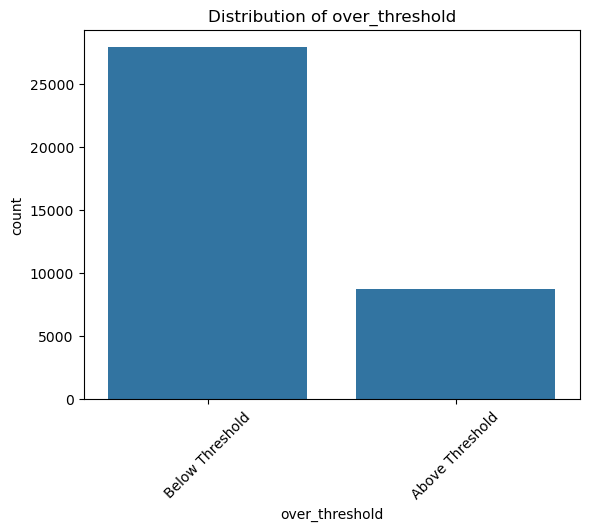

In [6]:
# 범주형 변수 추출
categorical_cols = df.select_dtypes(include='object').columns

# 범주형 변수 분포 확인
for col in categorical_cols:
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


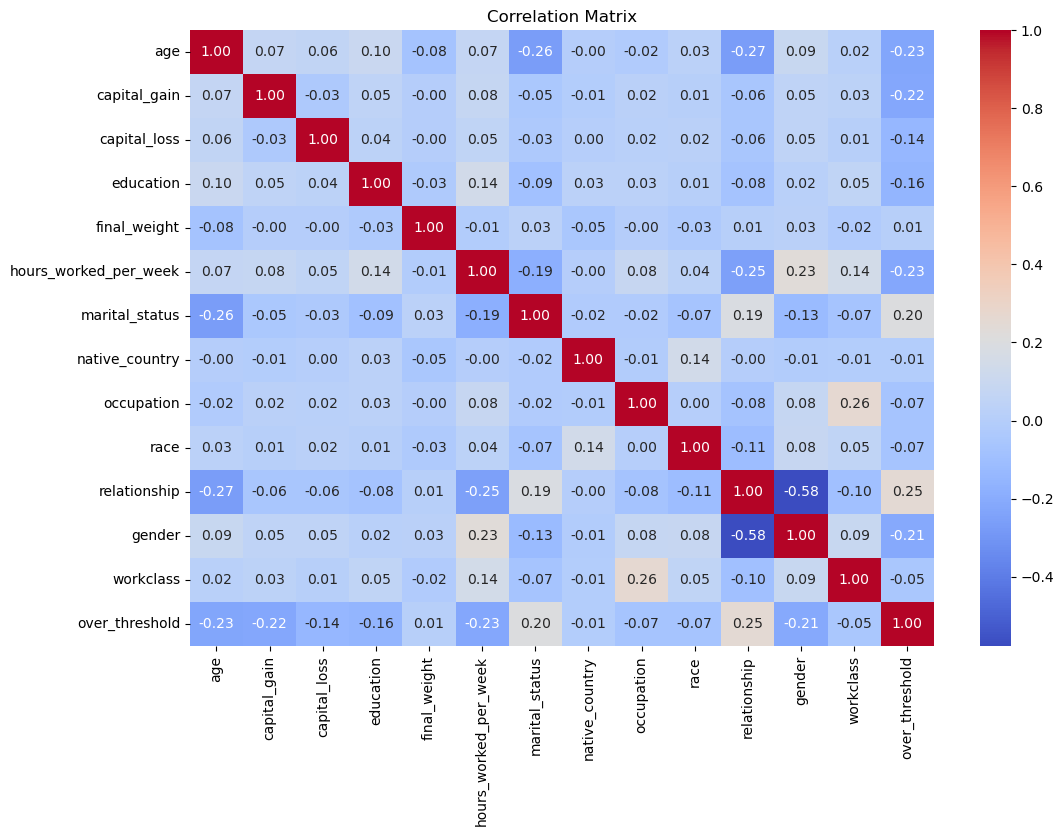

Label Encoding 후 데이터 샘플:
   age  capital_gain  capital_loss  education  final_weight  \
0   43           0.0           0.0          7         34278   
1   23           0.0           0.0          4        244698   
2   39           0.0           0.0          7        118286   
3   35           0.0           0.0         11        126675   
4   66           0.0           0.0          9         28367   

   hours_worked_per_week  marital_status  native_country  occupation  race  \
0                     35               2              39          12     4   
1                     35               4              26           5     4   
2                     40               2              39          12     2   
3                     46               0               0           3     4   
4                     99               2              39           9     4   

   relationship  gender  workclass  over_threshold  
0             0       1          4               1  
1             2      

In [7]:
# 범주형 변수를 숫자형으로 변환 (Label Encoding)
from sklearn.preprocessing import LabelEncoder

encoded_df = df.copy()

label_encoders = {}
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# 상관계수 계산 (새 데이터프레임 기준)
correlation = encoded_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('../images/label_encoding_correlation_heatmap.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

# 변환된 데이터 확인
print("Label Encoding 후 데이터 샘플:")
print(encoded_df.head())

# LabelEncoders 정보 확인 (변환된 매핑 정보)
for column, le in label_encoders.items():
    print(f"\n{column} Label Mapping:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))


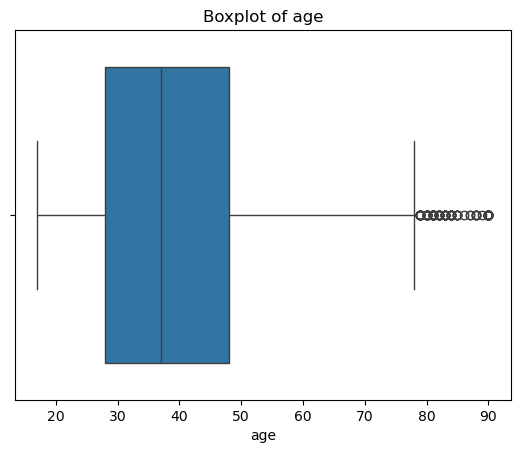

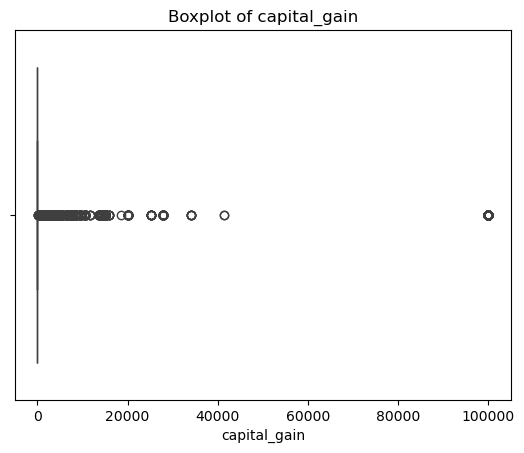

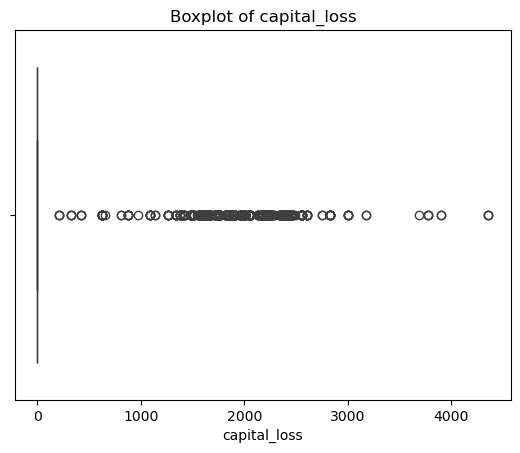

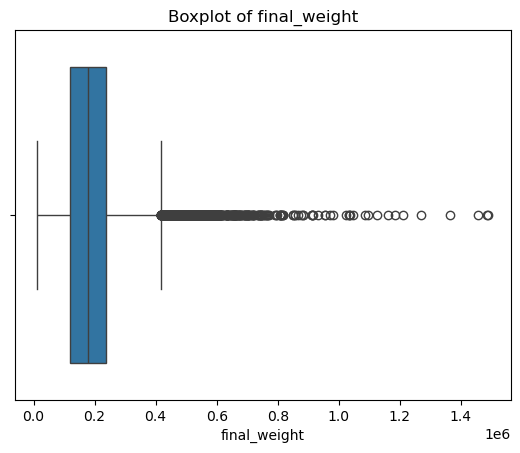

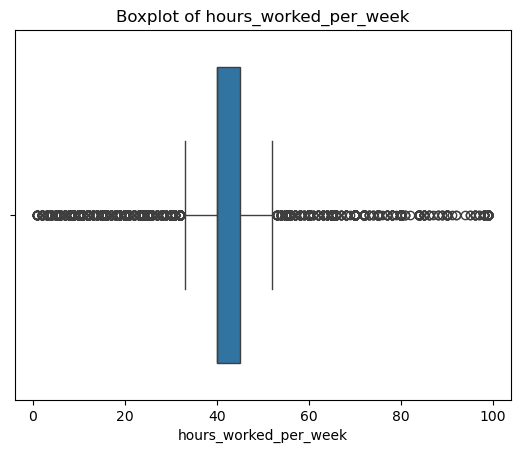

In [8]:
# 수치형 변수의 박스 플롯
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### outlier 분석석

In [9]:
from scipy.stats import zscore

# 숫자형 열만 선택 (encoded_df 사용)
encoded_numeric_cols = encoded_df.select_dtypes(include='number').columns

# Z-Score 계산
z_scores = encoded_df[encoded_numeric_cols].apply(zscore)

# Z-Score가 3을 초과하는 이상치 탐지
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"이상치 데이터 수: {outliers.sum()}")

# 이상치 데이터 추출
outliers_data = encoded_df[outliers]
print("\n이상치 데이터 샘플:")
print(outliers_data)

이상치 데이터 수: 5563

이상치 데이터 샘플:
       age  capital_gain  capital_loss  education  final_weight  \
3       35           0.0           0.0         11        126675   
4       66           0.0           0.0          9         28367   
7       39           0.0           0.0         15        167106   
12      30           0.0           0.0         12        119197   
14      37       27828.0           0.0         12        109133   
...    ...           ...           ...        ...           ...   
36605   36           0.0        1902.0         11        531055   
36620   35           0.0           0.0          6        167990   
36621   24           0.0           0.0          7        214542   
36625   42       27828.0           0.0         14         46221   
36629   53           0.0           0.0         12         92565   

       hours_worked_per_week  marital_status  native_country  occupation  \
3                         46               0               0           3   
4             

### wrong answer data 분석
전체 데이터셋으로 finetuning후에도 틀리는 데이터들들

In [10]:
# JSON 파일 로드
file_path = '../data/adult_train_wrong_answer.json'
with open(file_path, 'r') as file:
    wrong_predictions = json.load(file)

# 데이터프레임으로 변환
df_wrong = pd.DataFrame(wrong_predictions)

# 데이터 확인
print("데이터 샘플:")
print(df_wrong.head())

데이터 샘플:
   age  capital_gain  capital_loss    education  final_weight  \
0   32             0             0  Prof-school        303692   
1   29             0             0      HS-grad        229124   
2   37             0             0    Bachelors        355856   
3   40             0             0   Assoc-acdm         34178   
4   37             0             0      HS-grad         32528   

   hours_worked_per_week      marital_status native_country      occupation  \
0                     40            Divorced  United-States  Prof-specialty   
1                     48  Married-civ-spouse  United-States    Adm-clerical   
2                     40  Married-civ-spouse       Cambodia    Craft-repair   
3                     40            Divorced  United-States    Craft-repair   
4                     40  Married-civ-spouse        England    Adm-clerical   

                 race   relationship  gender    workclass  over_threshold  \
0               White  Not-in-family       0     

In [11]:
# gender와 over_threshold를 범주형 데이터로 변환
df_wrong['gender'] = df_wrong['gender'].apply(lambda x: 'Male' if x == 0 else 'Female')

df_wrong['over_threshold'] = df_wrong['over_threshold'].apply(lambda x: 'Below Threshold' if x == 0 else 'Above Threshold')
df_wrong['prediction'] = df_wrong['prediction'].apply(lambda x: 'Below Threshold' if x == 0 else 'Above Threshold')

# 데이터 타입을 범주형으로 명시적으로 설정
df_wrong['gender'] = df_wrong['gender'].astype('object')
df_wrong['over_threshold'] = df_wrong['over_threshold'].astype('object')
df_wrong['prediction'] = df_wrong['prediction'].astype('object')

# 변환 후 데이터 확인
print("변환된 데이터 샘플:")
print(df_wrong[['gender', 'over_threshold', 'prediction']].head())
print("\n변수 데이터 타입:")
print(df_wrong.dtypes)

변환된 데이터 샘플:
  gender   over_threshold       prediction
0   Male  Above Threshold  Below Threshold
1   Male  Above Threshold  Below Threshold
2   Male  Above Threshold  Below Threshold
3   Male  Above Threshold  Below Threshold
4   Male  Above Threshold  Below Threshold

변수 데이터 타입:
age                       int64
capital_gain              int64
capital_loss              int64
education                object
final_weight              int64
hours_worked_per_week     int64
marital_status           object
native_country           object
occupation               object
race                     object
relationship             object
gender                   object
workclass                object
over_threshold           object
prediction               object
dtype: object


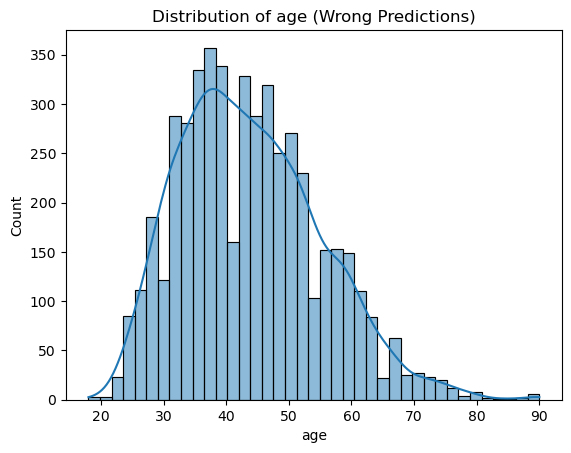

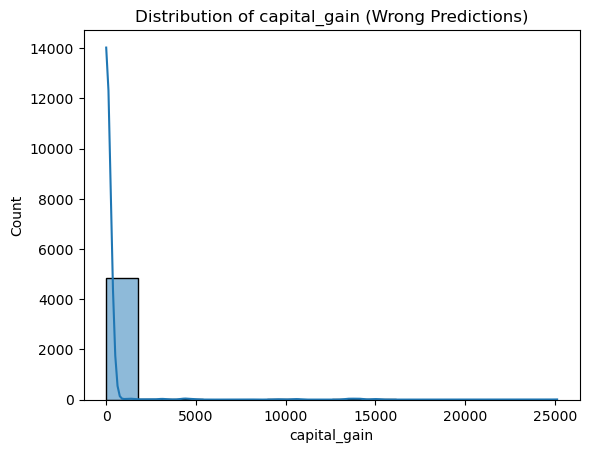

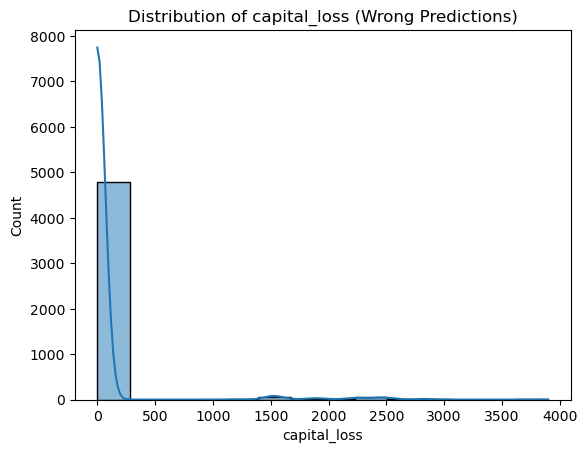

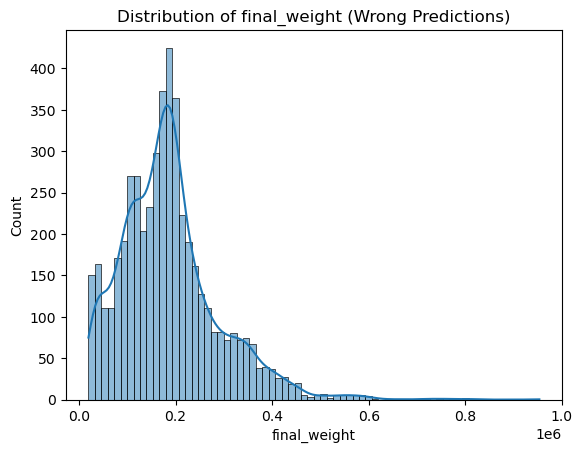

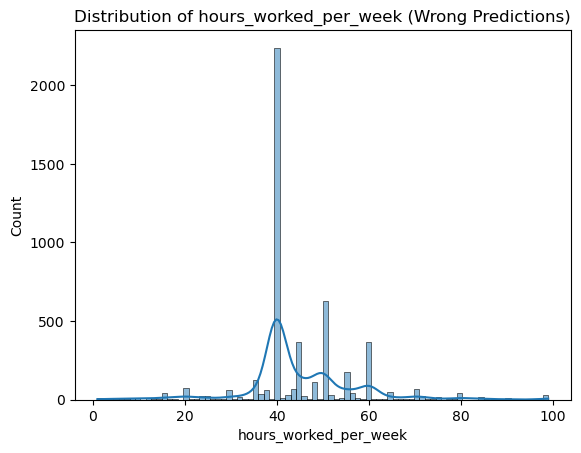

In [12]:
# 수치형 변수 추출
numeric_cols = df_wrong.select_dtypes(include='number').columns

# 히스토그램 시각화
for col in numeric_cols:
    sns.histplot(df_wrong[col], kde=True)
    plt.title(f'Distribution of {col} (Wrong Predictions)')
    plt.show()

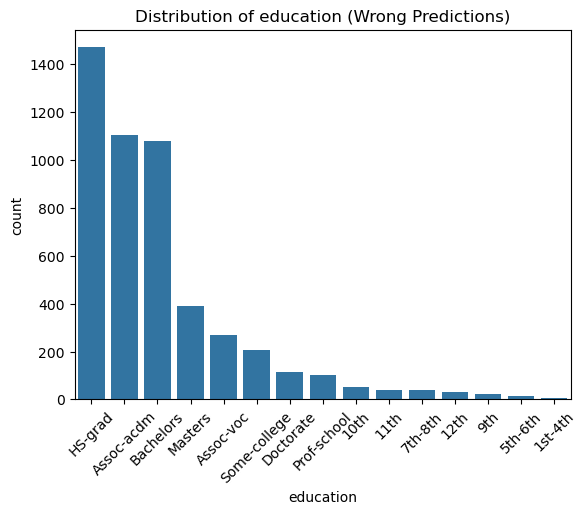

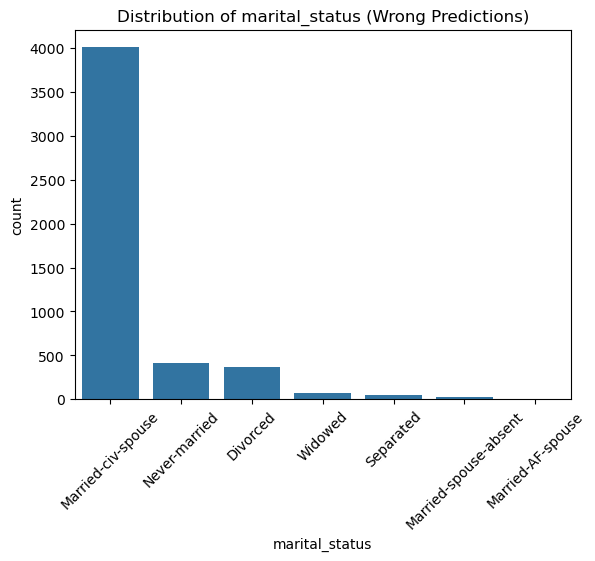

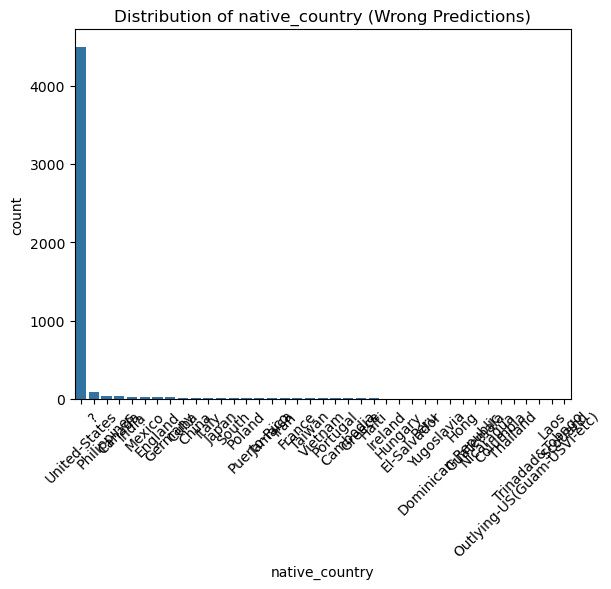

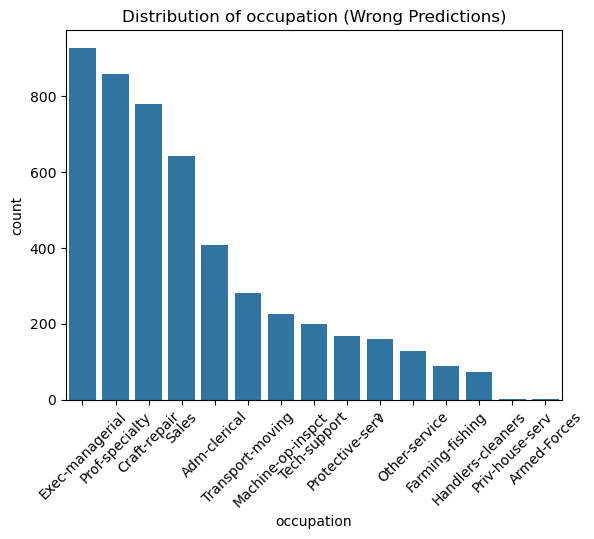

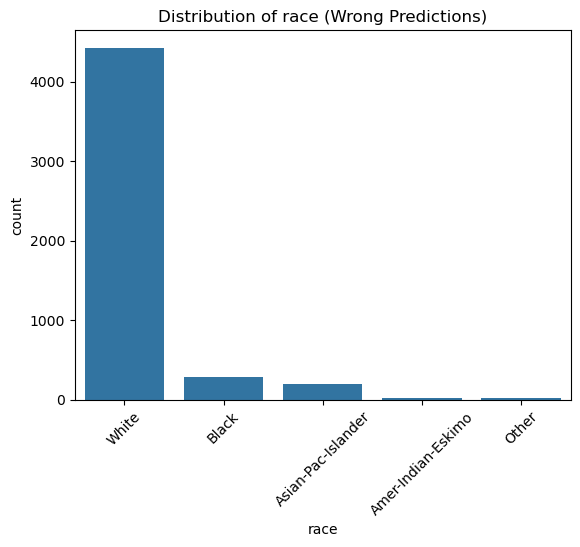

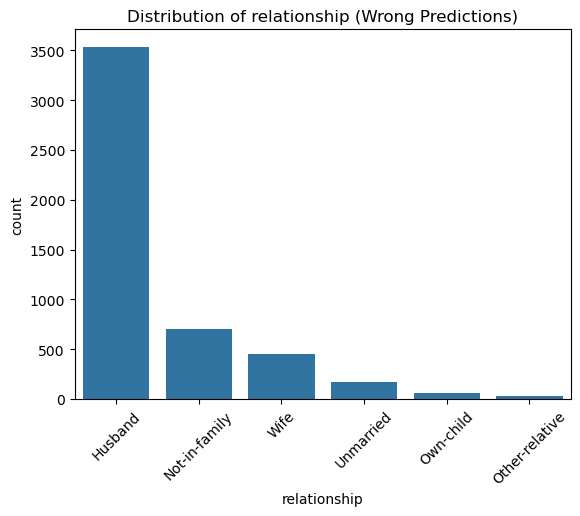

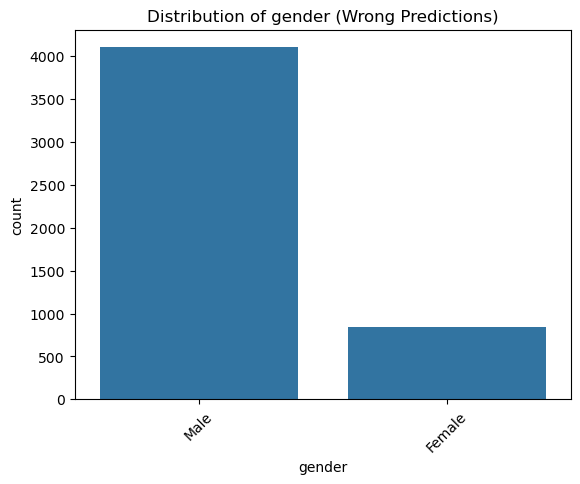

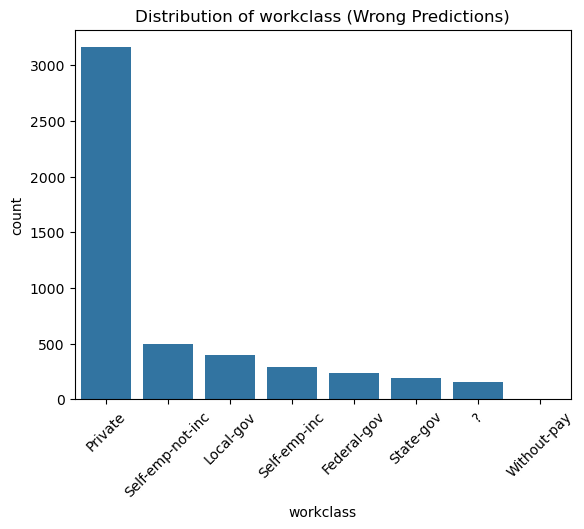

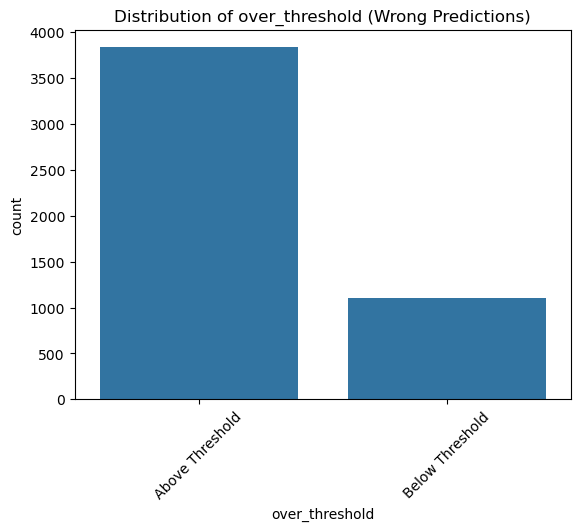

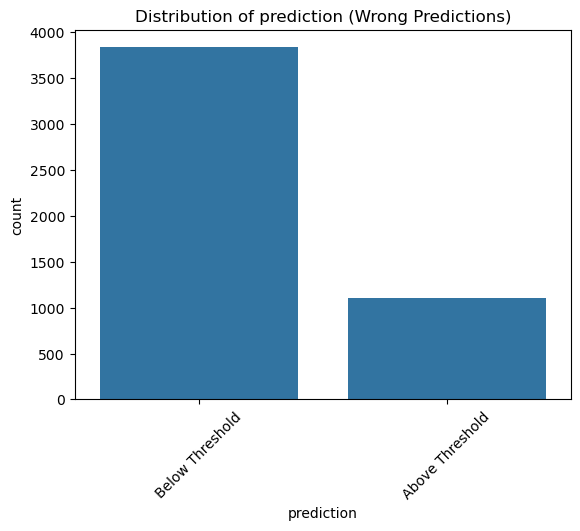

In [13]:
# 범주형 변수 추출
categorical_cols = df_wrong.select_dtypes(include='object').columns

# 범주형 변수의 분포 확인
for col in categorical_cols:
    sns.countplot(x=col, data=df_wrong, order=df_wrong[col].value_counts().index)
    plt.title(f'Distribution of {col} (Wrong Predictions)')
    plt.xticks(rotation=45)
    plt.show()


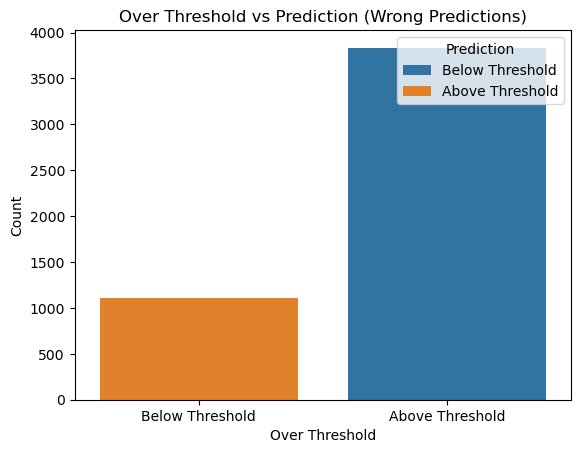

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# over_threshold와 prediction 간의 교차 분포
sns.countplot(x='over_threshold', hue='prediction', data=df_wrong, order=['Below Threshold', 'Above Threshold'])
plt.title('Over Threshold vs Prediction (Wrong Predictions)')
plt.xlabel('Over Threshold')
plt.ylabel('Count')
plt.legend(title='Prediction', loc='upper right')
plt.show()


Confusion Matrix:
Predicted        Above Threshold  Below Threshold
Actual                                           
Above Threshold                0             3835
Below Threshold             1107                0


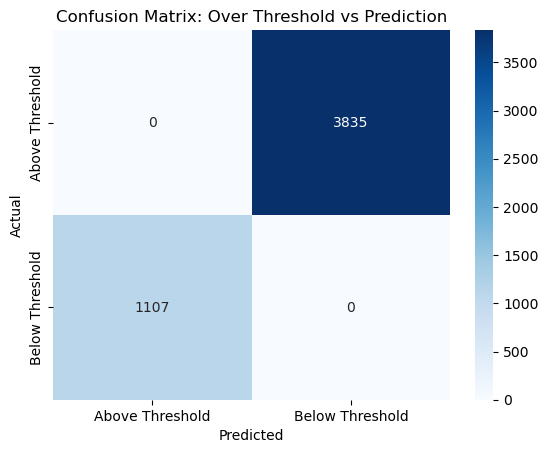

In [15]:
import pandas as pd

# 혼동 행렬 계산
confusion_matrix = pd.crosstab(df_wrong['over_threshold'], df_wrong['prediction'], rownames=['Actual'], colnames=['Predicted'])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(confusion_matrix)

# 혼동 행렬 히트맵 시각화
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Over Threshold vs Prediction')
plt.show()


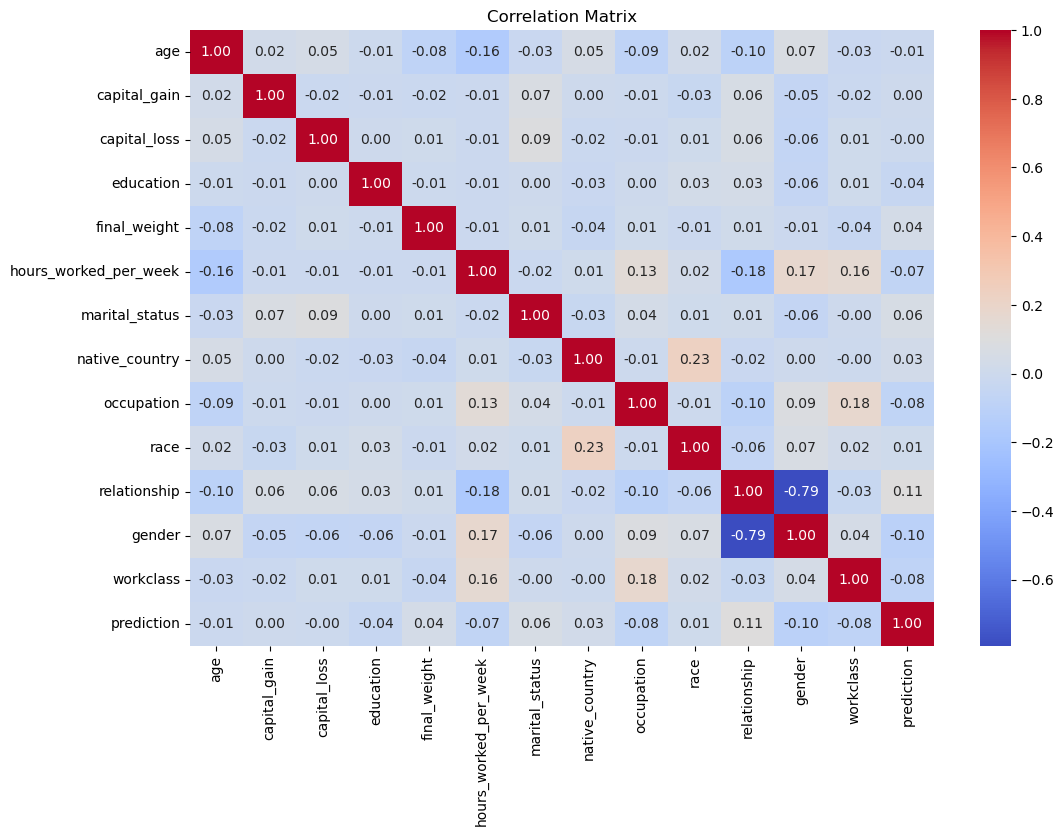

Label Encoding 후 데이터 샘플:
   age  capital_gain  capital_loss  education  final_weight  \
0   32             0             0         13        303692   
1   29             0             0         11        229124   
2   37             0             0          9        355856   
3   40             0             0          7         34178   
4   37             0             0         11         32528   

   hours_worked_per_week  marital_status  native_country  occupation  race  \
0                     40               0              36          10     4   
1                     48               2              36           1     4   
2                     40               2               1           3     1   
3                     40               0              36           3     4   
4                     40               2               8           1     4   

   relationship  gender  workclass  prediction  
0             1       1          3           1  
1             0       1      

In [16]:
# 범주형 변수를 숫자형으로 변환 (Label Encoding)
from sklearn.preprocessing import LabelEncoder

encoded_df_wrong = df_wrong.copy()

label_encoders = {}
for column in df_wrong.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df_wrong[column] = le.fit_transform(df_wrong[column])
    label_encoders[column] = le

encoded_df_wrong.drop(columns=['over_threshold'], inplace=True)
# 상관계수 계산 (새 데이터프레임 기준)
correlation = encoded_df_wrong.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('../images/label_encoding_correlation_heatmap.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

# 변환된 데이터 확인
print("Label Encoding 후 데이터 샘플:")
print(encoded_df_wrong.head())

# LabelEncoders 정보 확인 (변환된 매핑 정보)
for column, le in label_encoders.items():
    print(f"\n{column} Label Mapping:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))


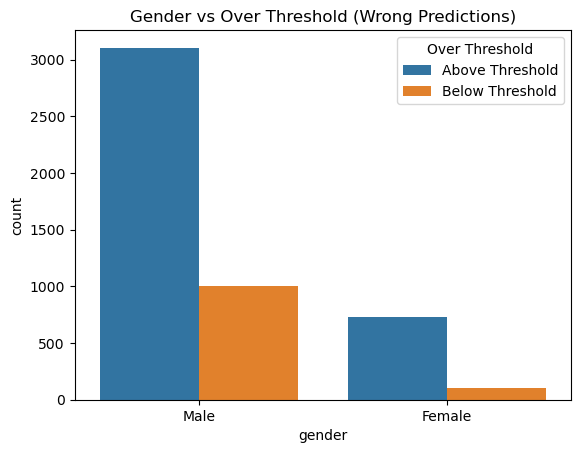

In [17]:
# 성별에 따른 분포
sns.countplot(x='gender', hue='over_threshold', data=df_wrong)
plt.title('Gender vs Over Threshold (Wrong Predictions)')
plt.legend(title='Over Threshold', loc='upper right')
plt.show()

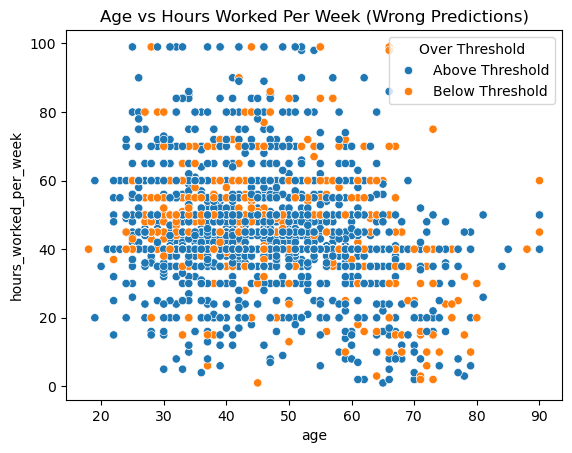

In [18]:
# 잘못 예측된 데이터에서 age와 hours_worked_per_week 간의 관계
sns.scatterplot(x='age', y='hours_worked_per_week', hue='over_threshold', data=df_wrong)
plt.title('Age vs Hours Worked Per Week (Wrong Predictions)')
plt.legend(title='Over Threshold')
plt.show()

### prediction vs target 분석석

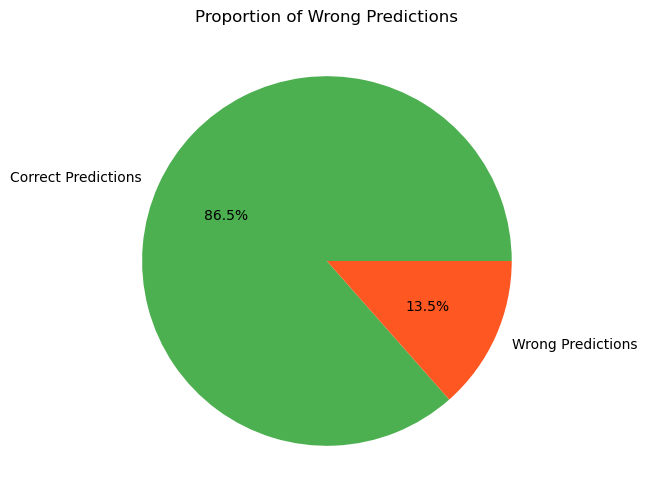

In [19]:
import matplotlib.pyplot as plt

# 전체 데이터 개수와 잘못 예측된 데이터 개수
total_count = len(df)
wrong_count = len(df_wrong)

# 비율 계산
labels = ['Correct Predictions', 'Wrong Predictions']
sizes = [total_count - wrong_count, wrong_count]

# 파이 차트
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FF5722'])
plt.title('Proportion of Wrong Predictions')
plt.show()


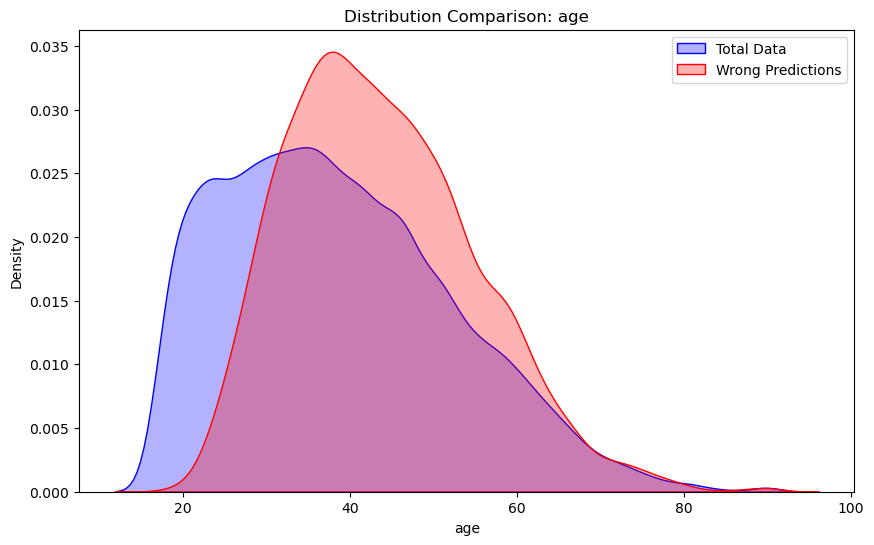

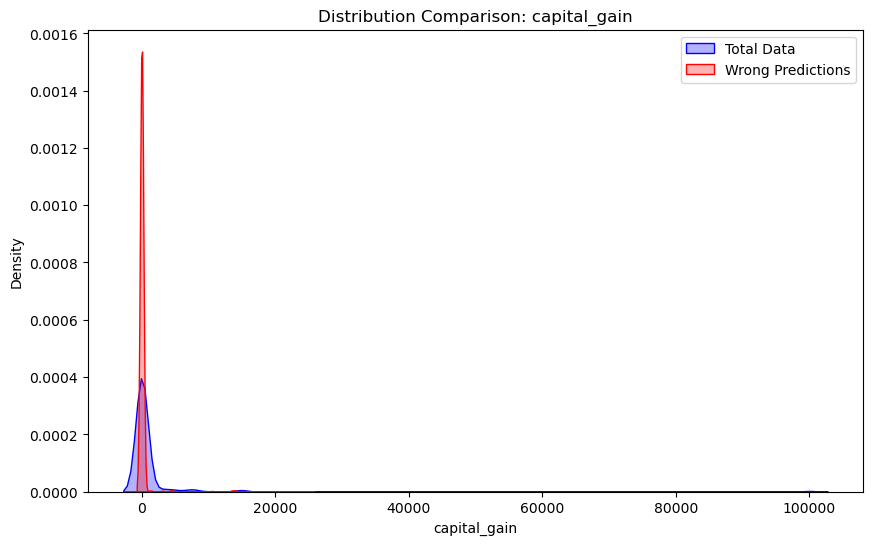

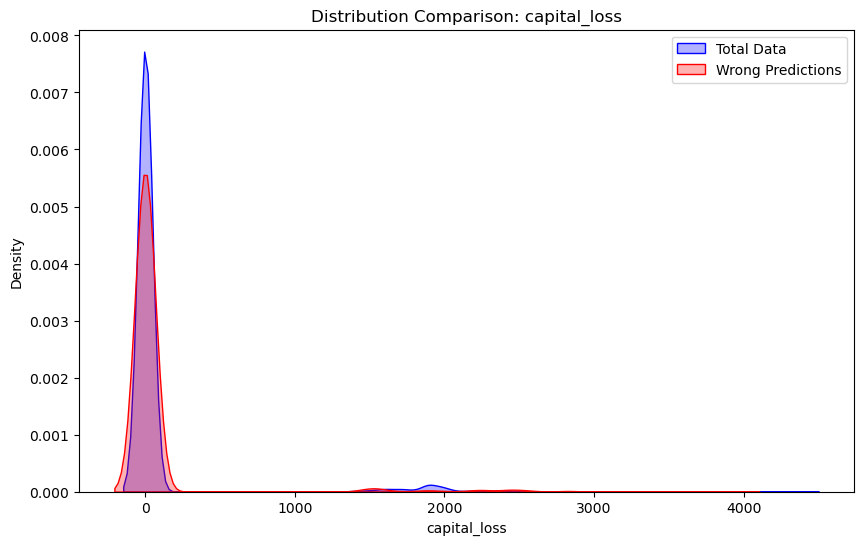

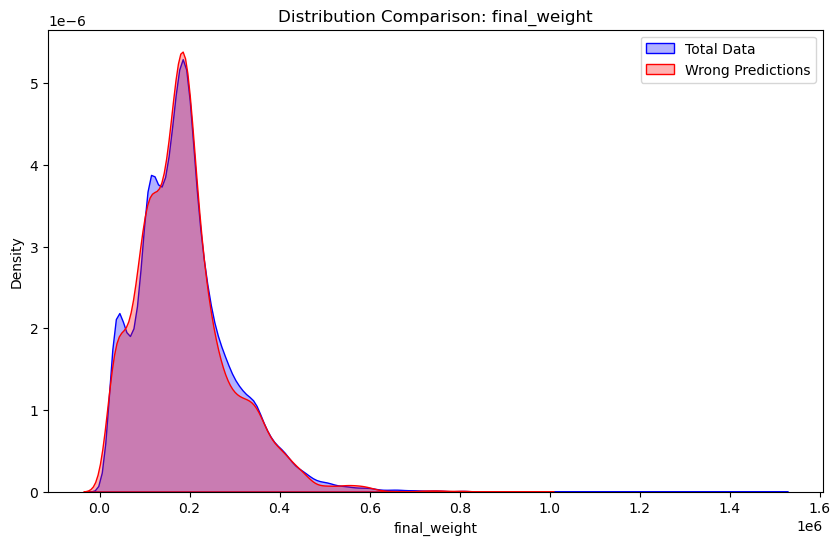

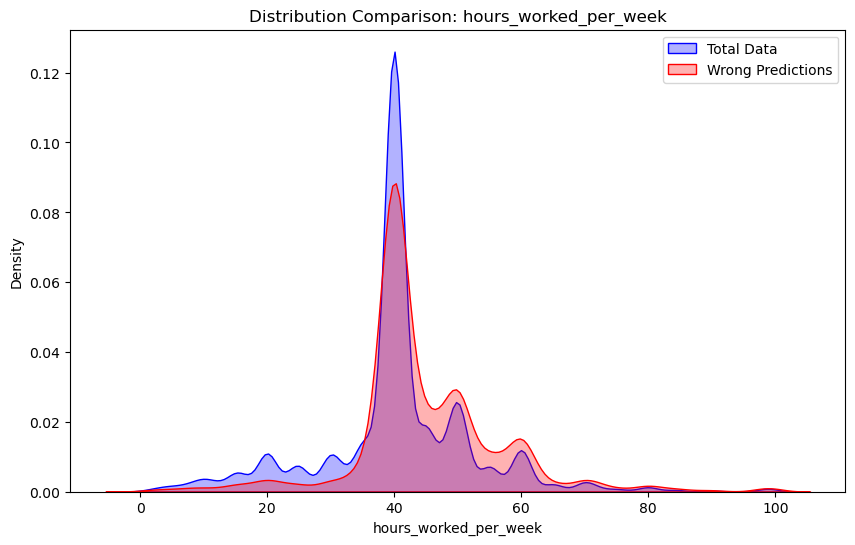

In [20]:
import seaborn as sns

# 수치형 변수 추출
numeric_cols = df.select_dtypes(include='number').columns

# 각 수치형 변수의 전체 데이터와 잘못 예측 데이터 비교
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data=df, x=col, label='Total Data', color='blue', fill=True, alpha=0.3)
    sns.kdeplot(data=df_wrong, x=col, label='Wrong Predictions', color='red', fill=True, alpha=0.3)
    
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
    plt.show()


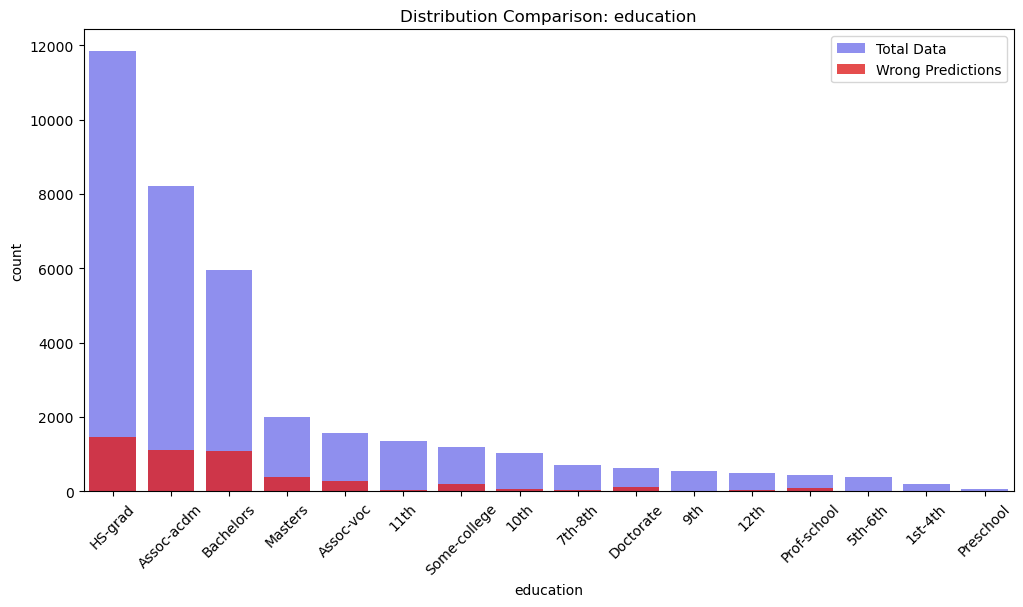

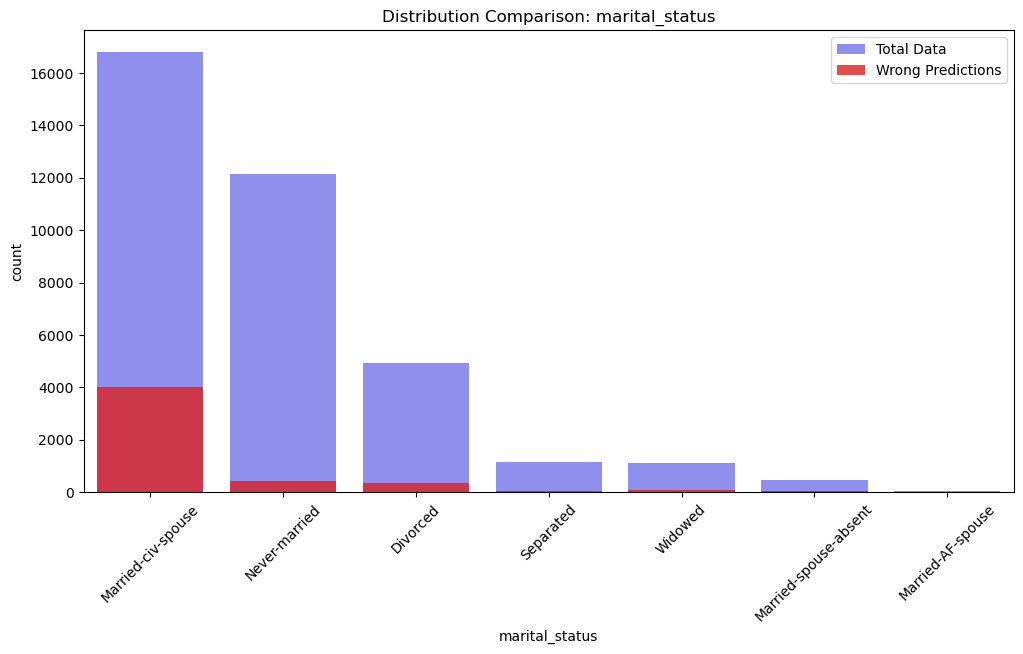

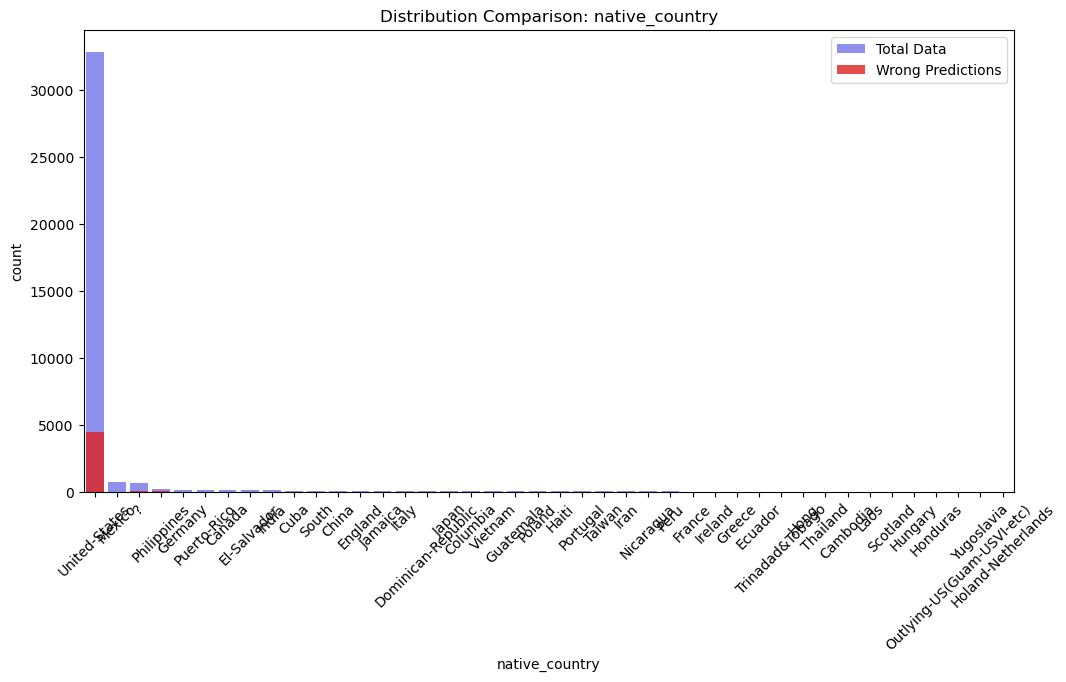

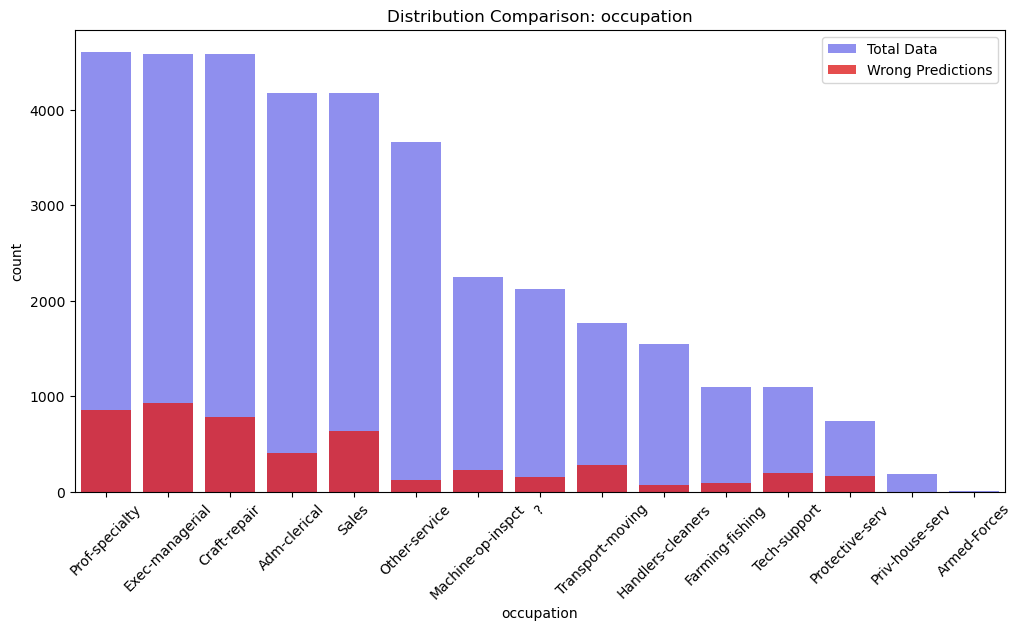

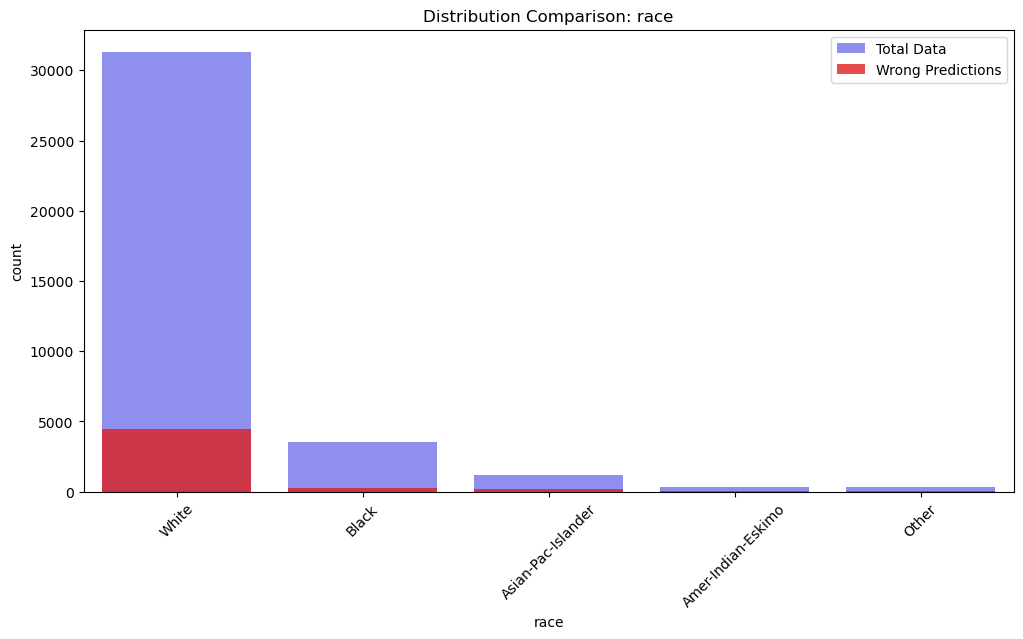

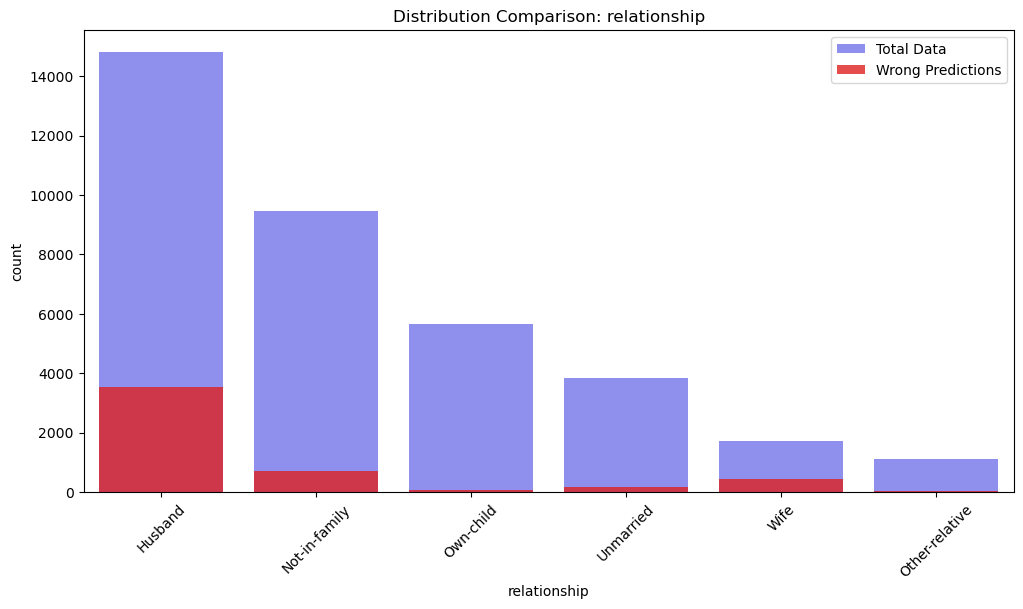

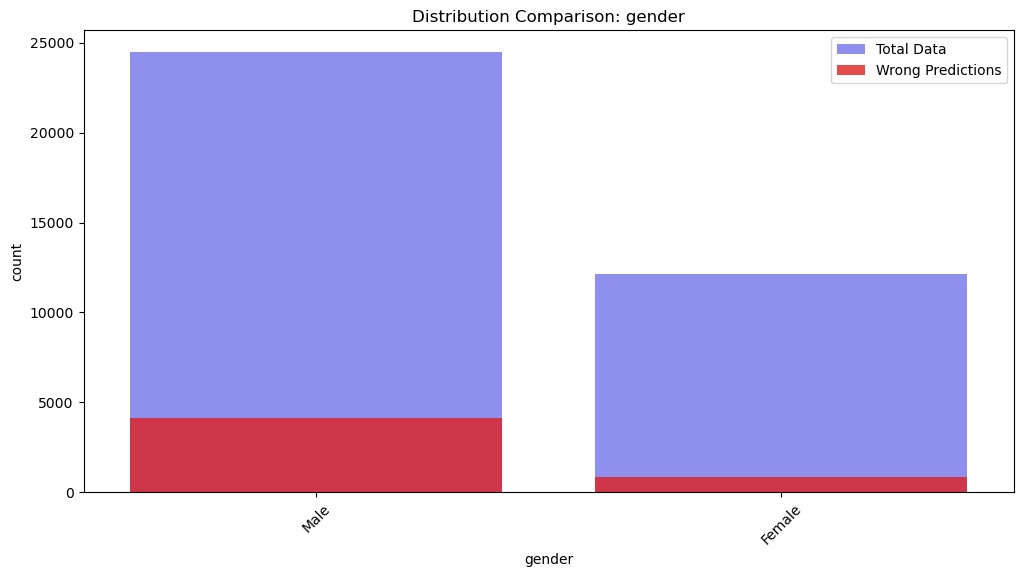

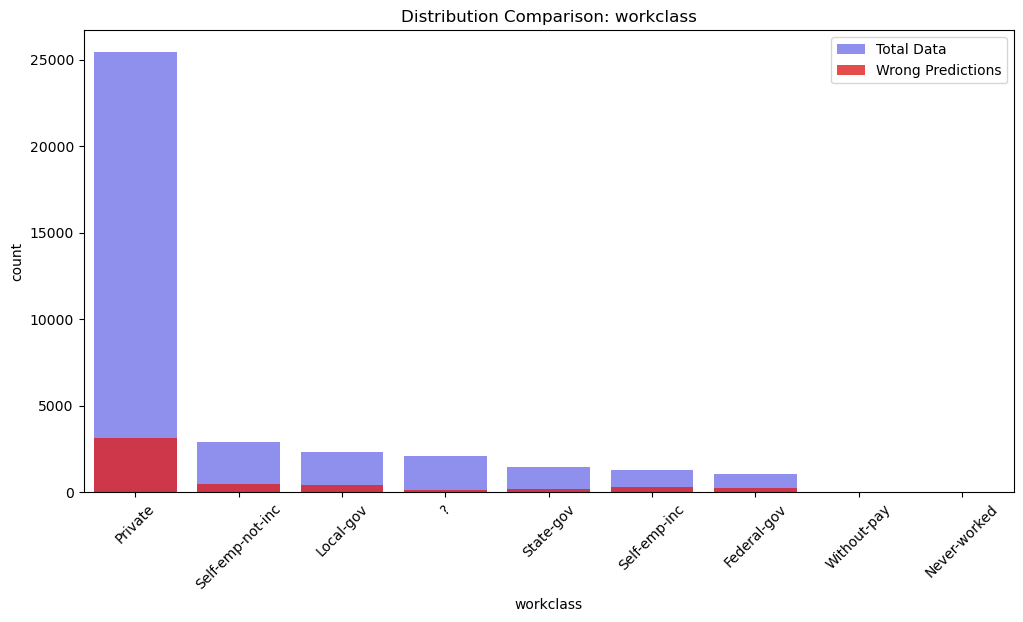

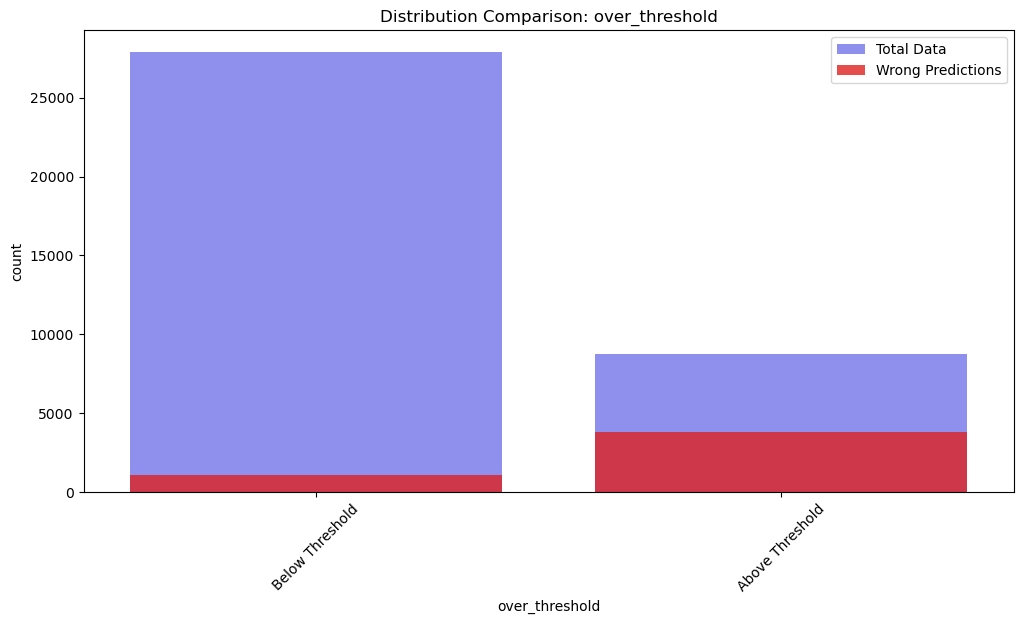

In [21]:
# 범주형 변수 추출
categorical_cols = df.select_dtypes(include='object').columns

# 각 범주형 변수의 전체 데이터와 잘못 예측 데이터 비교
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    
    sns.countplot(x=col, data=df, alpha=0.5, label='Total Data', color='blue', order=df[col].value_counts().index)
    sns.countplot(x=col, data=df_wrong, alpha=0.8, label='Wrong Predictions', color='red', order=df[col].value_counts().index)
    
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


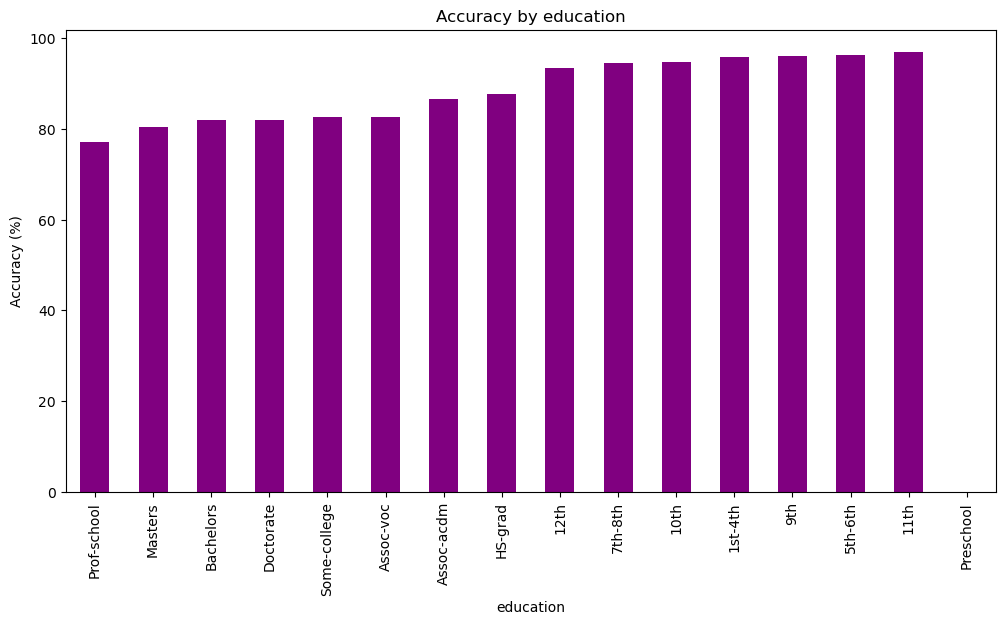

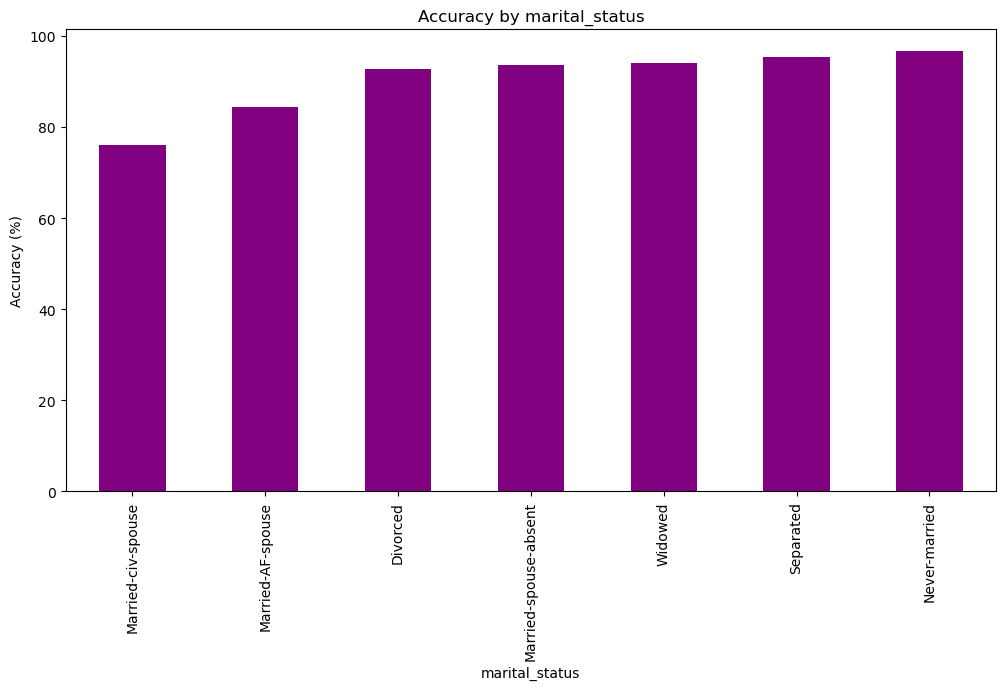

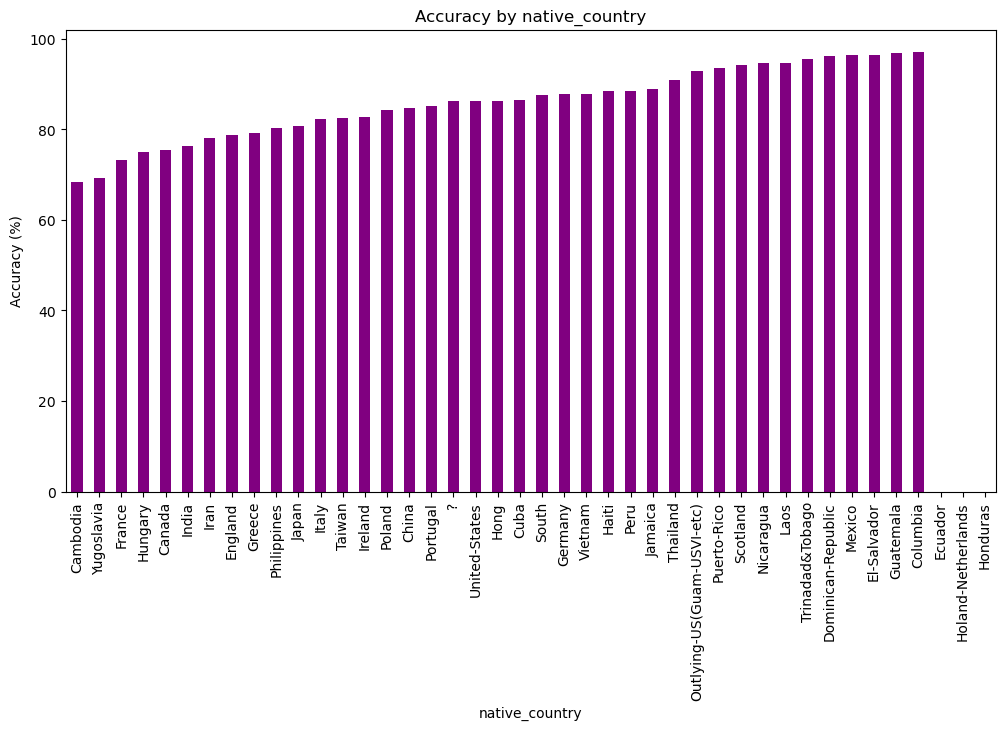

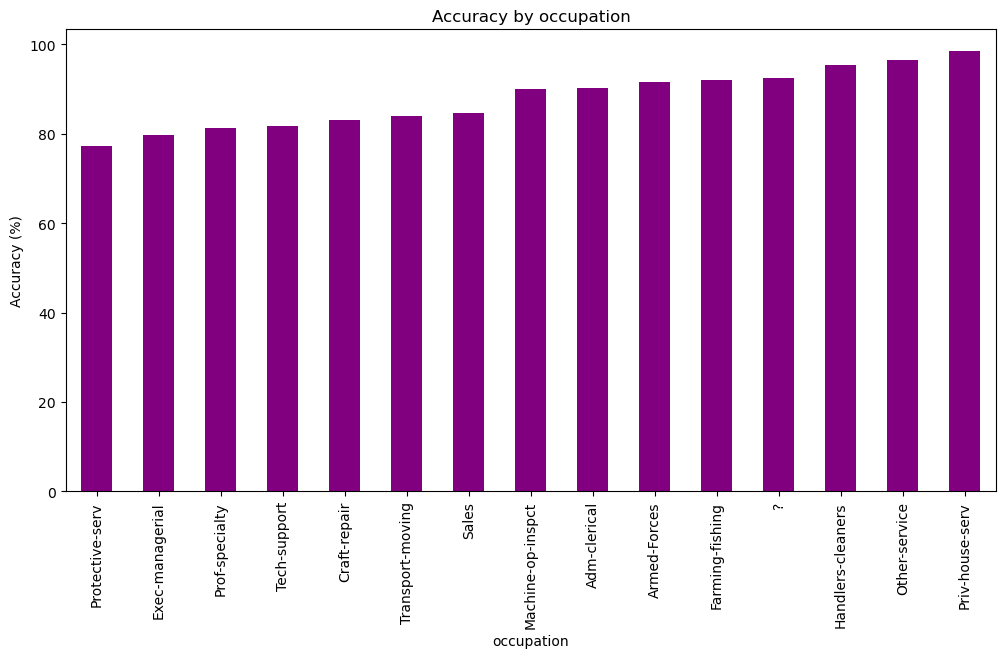

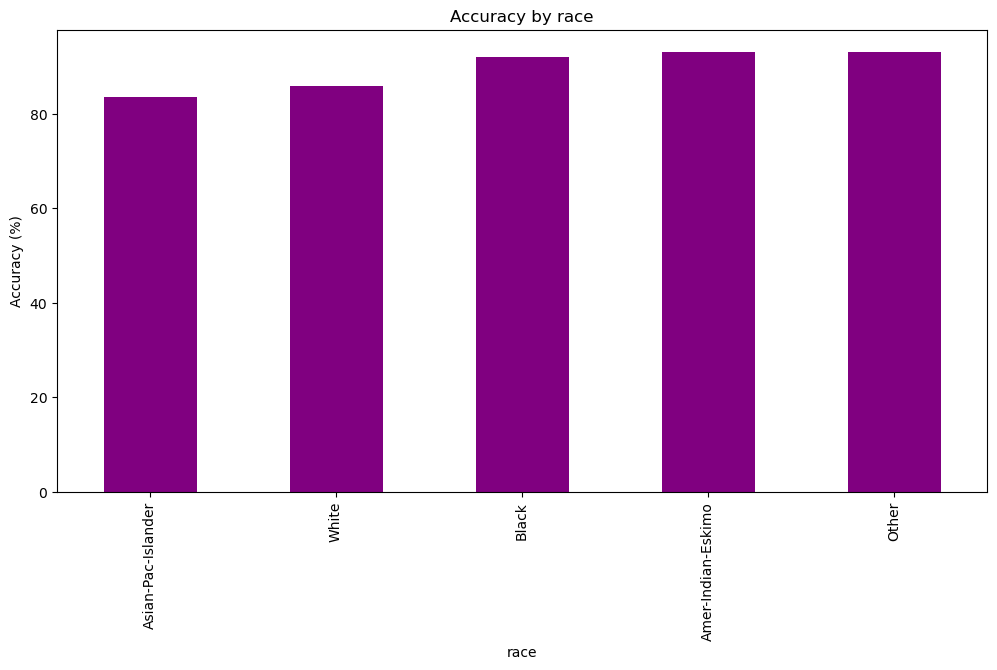

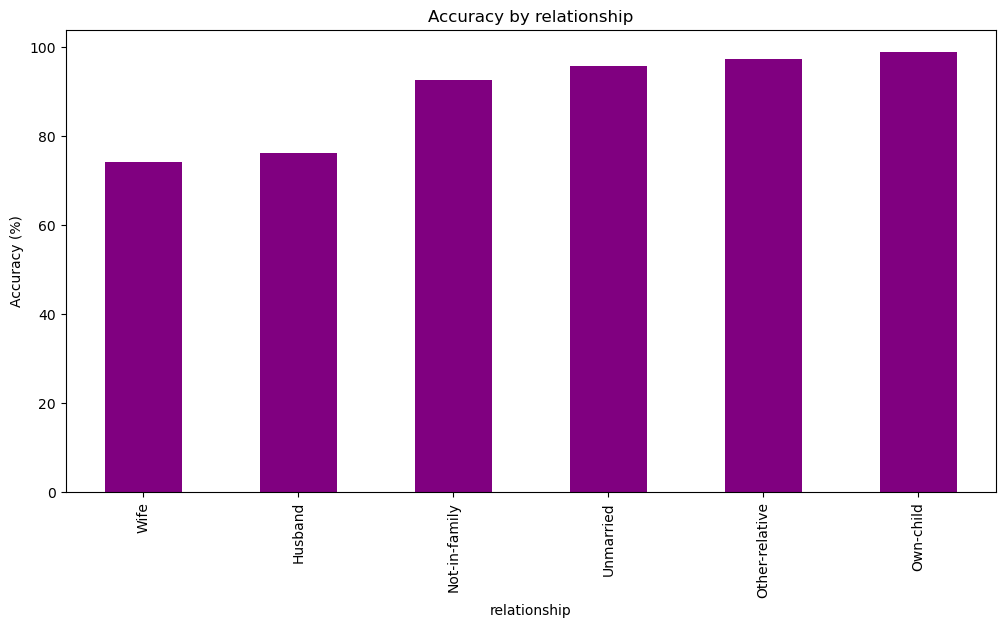

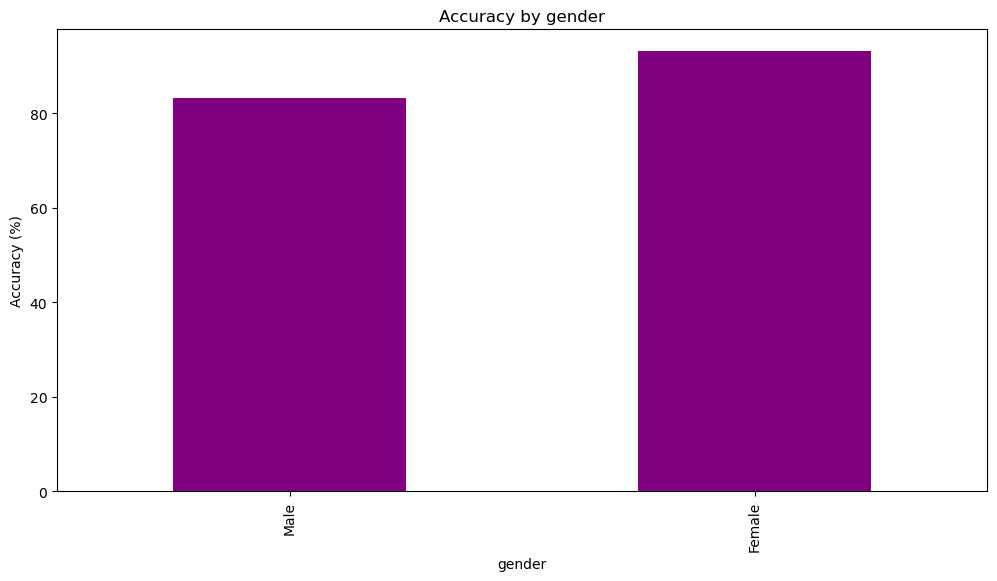

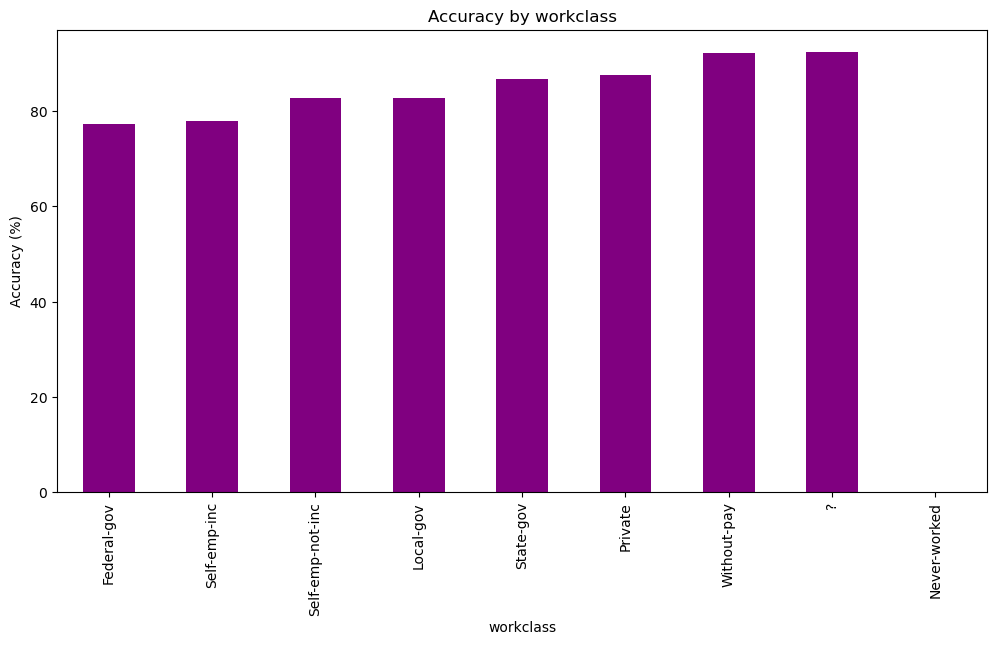

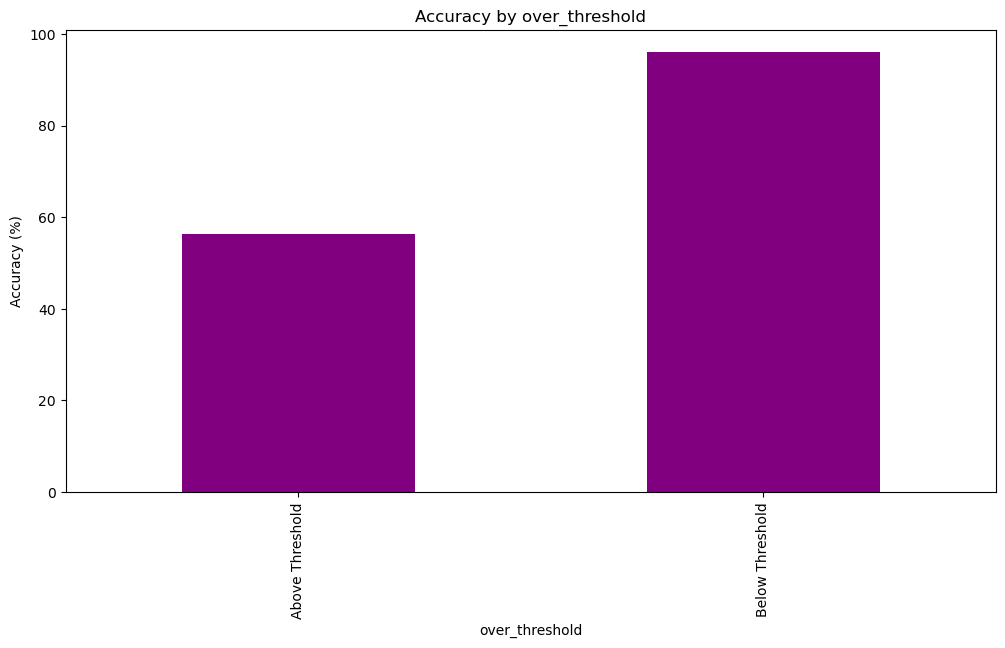

In [22]:
# 범주형 변수에서 정확도 비교
for col in categorical_cols:
    total_counts = df[col].value_counts()
    wrong_counts = df_wrong[col].value_counts()

    accuracy = (total_counts - wrong_counts) / total_counts * 100

    plt.figure(figsize=(12, 6))
    accuracy.sort_values().plot(kind='bar', color='purple')
    plt.title(f'Accuracy by {col}')
    plt.ylabel('Accuracy (%)')
    plt.xlabel(col)
    plt.show()


### wrong answer중 outlier 분석석

In [23]:
# 이상치 탐지 및 df_wrong 포함 여부 확인
from scipy.stats import zscore
import pandas as pd

# 숫자형 열만 선택
numeric_cols = df.select_dtypes(include='number').columns

# Z-Score 계산
z_scores = df[numeric_cols].apply(zscore)

# 이상치 탐지 (Z-Score가 3 이상인 경우)
outliers = (z_scores.abs() > 3).any(axis=1)

# 이상치 여부 추가
df['is_outlier'] = outliers

# 잘못 예측된 데이터 중 이상치 비율
wrong_outliers = df_wrong.merge(df[['is_outlier']], left_index=True, right_index=True)
outlier_in_wrong = wrong_outliers['is_outlier'].sum()

# 결과 출력
print(f"전체 이상치 개수: {outliers.sum()}")
print(f"잘못 예측된 데이터 중 이상치 개수: {outlier_in_wrong}")
print(f"잘못 예측된 데이터 중 이상치 비율: {outlier_in_wrong / len(df_wrong):.2%}")


전체 이상치 개수: 2838
잘못 예측된 데이터 중 이상치 개수: 374
잘못 예측된 데이터 중 이상치 비율: 7.57%


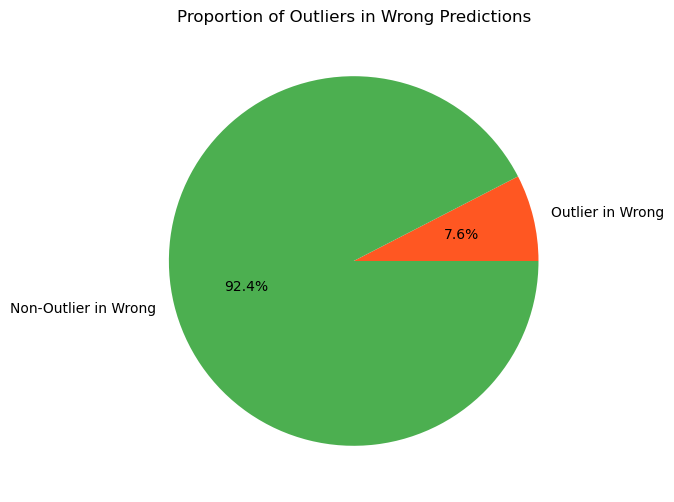

In [24]:
import matplotlib.pyplot as plt

# 이상치 포함 여부 비율
labels = ['Outlier in Wrong', 'Non-Outlier in Wrong']
sizes = [outlier_in_wrong, len(df_wrong) - outlier_in_wrong]

# 파이 차트
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#FF5722', '#4CAF50'])
plt.title('Proportion of Outliers in Wrong Predictions')
plt.show()


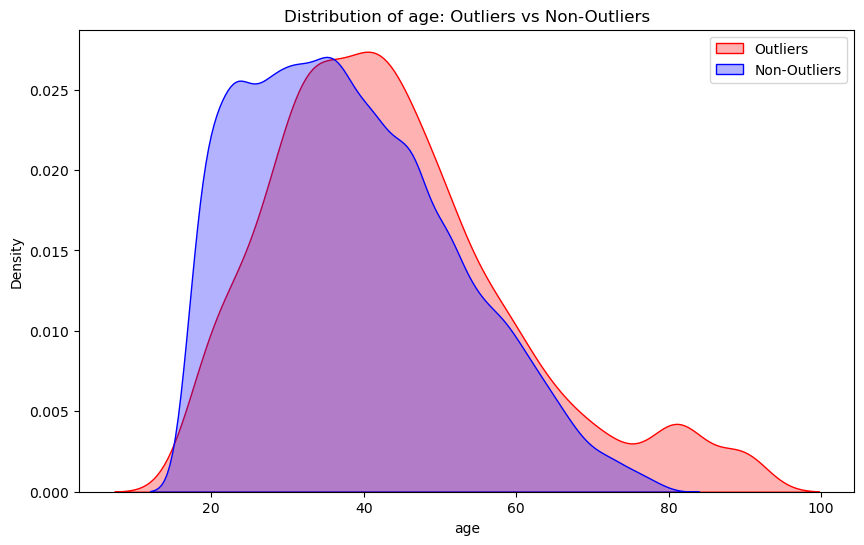

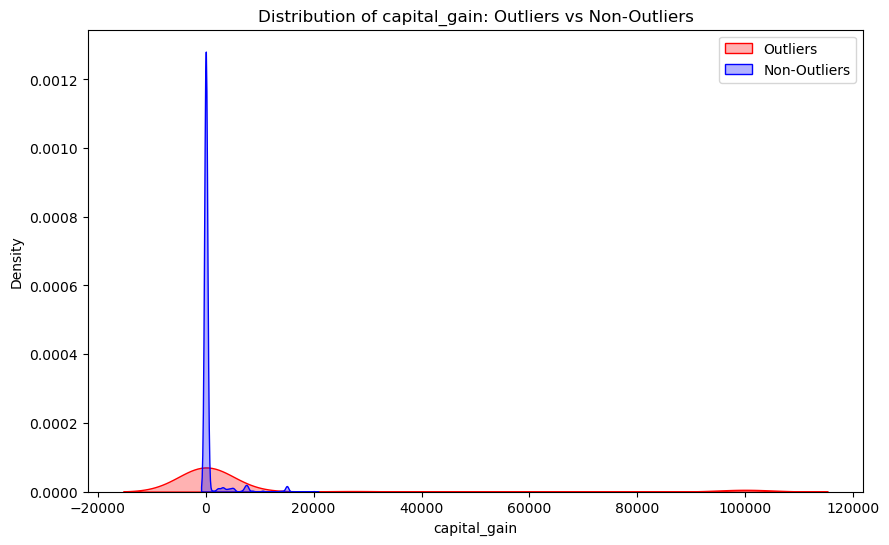

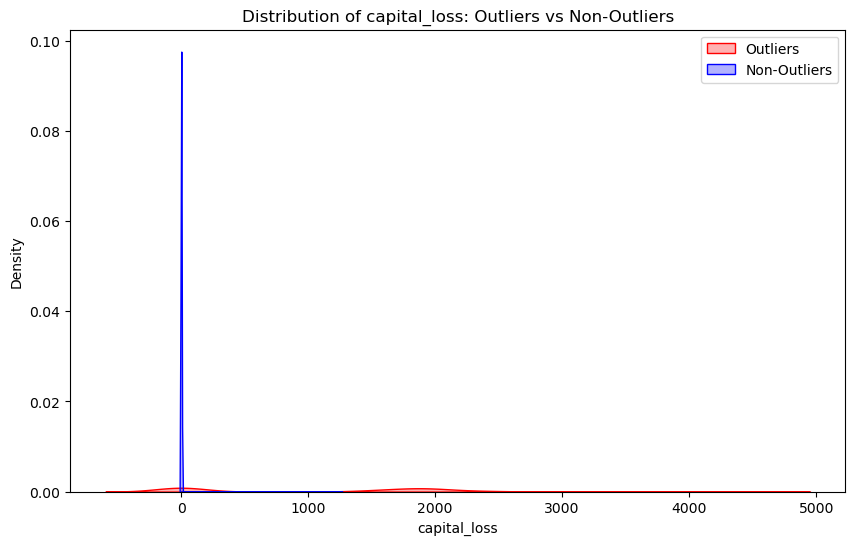

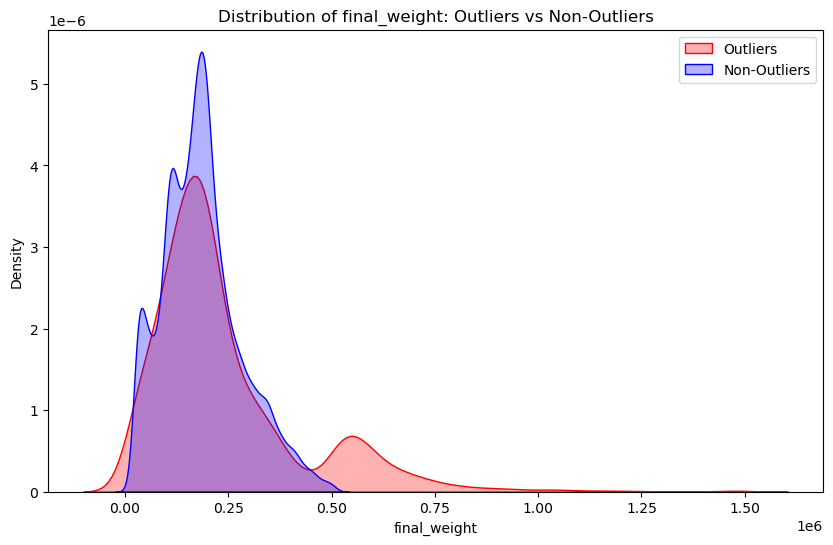

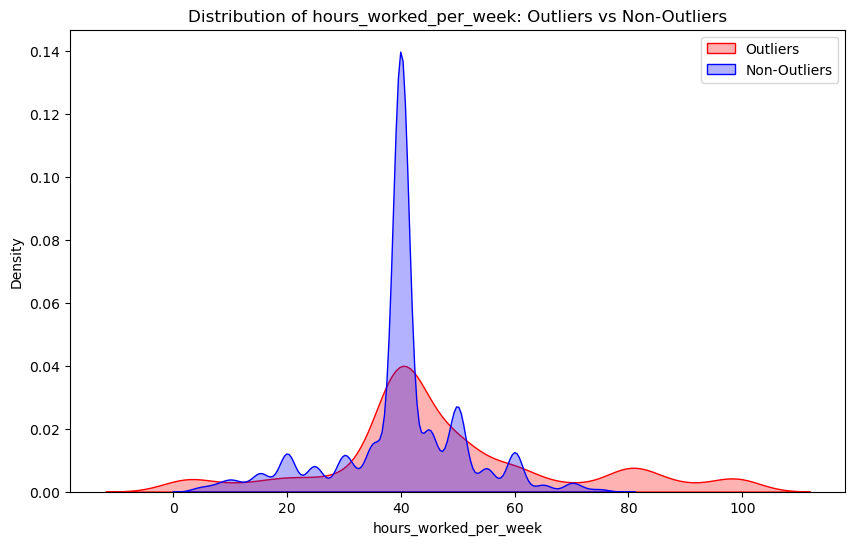

In [25]:
import seaborn as sns

# 수치형 변수의 이상치와 비이상치 분포 비교
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(df[df['is_outlier']][col], label='Outliers', color='red', fill=True, alpha=0.3)
    sns.kdeplot(df[~df['is_outlier']][col], label='Non-Outliers', color='blue', fill=True, alpha=0.3)
    
    plt.title(f'Distribution of {col}: Outliers vs Non-Outliers')
    plt.legend()
    plt.show()


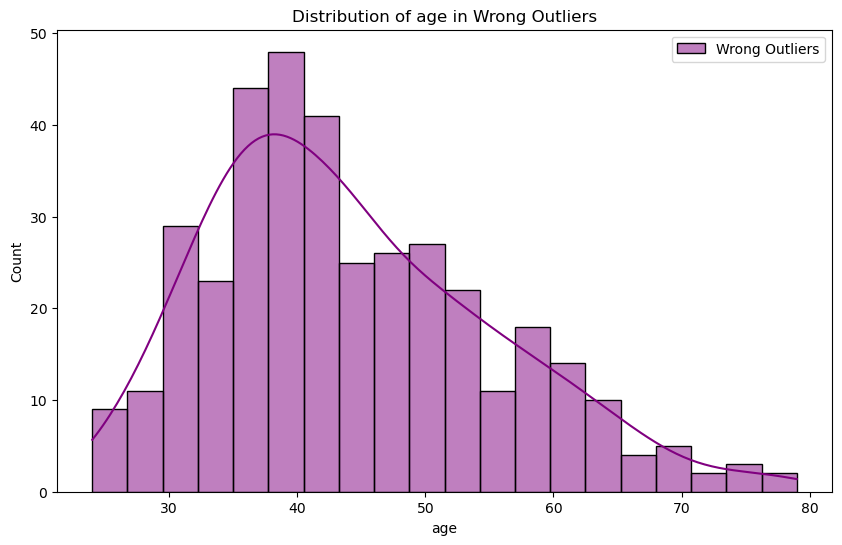

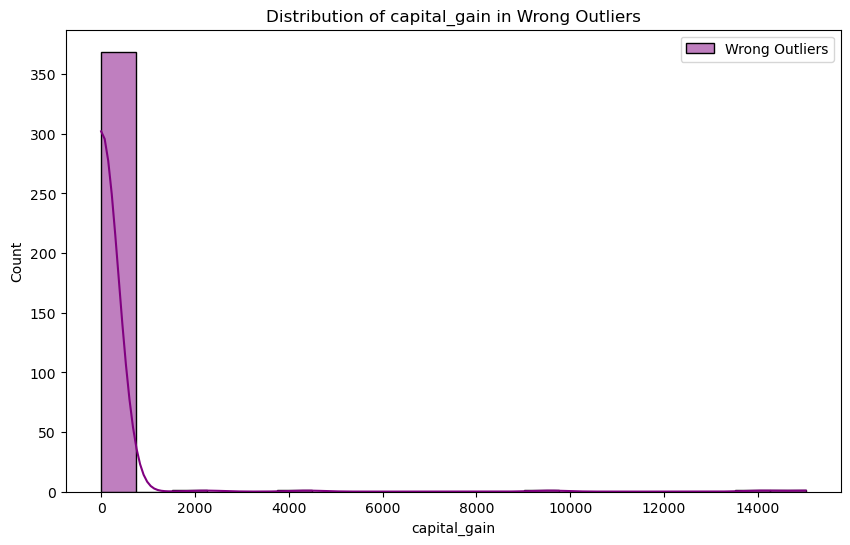

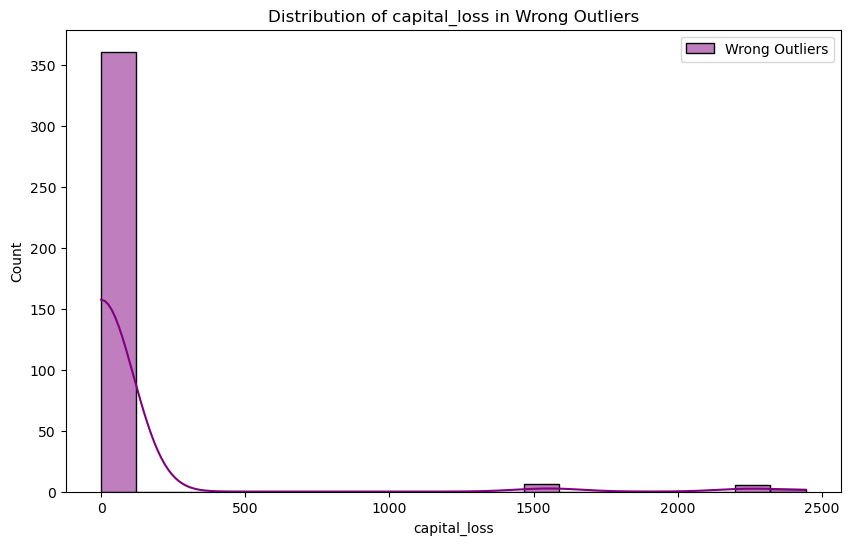

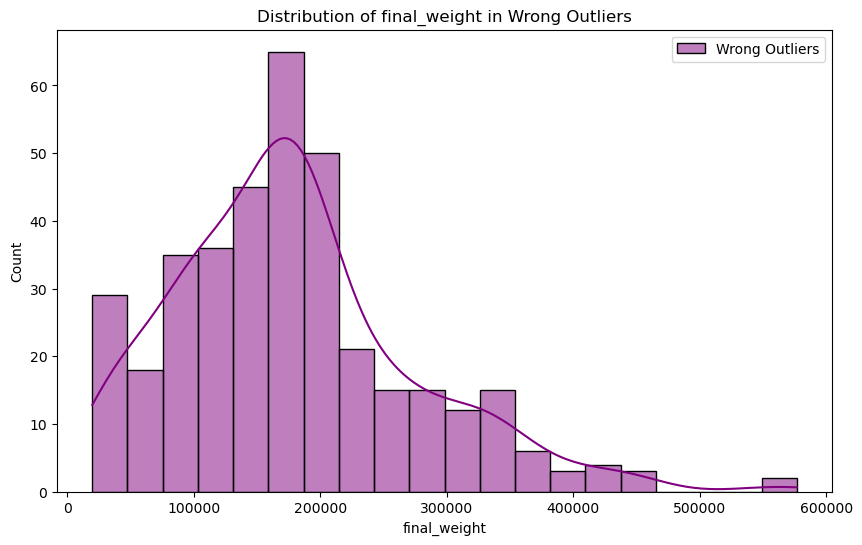

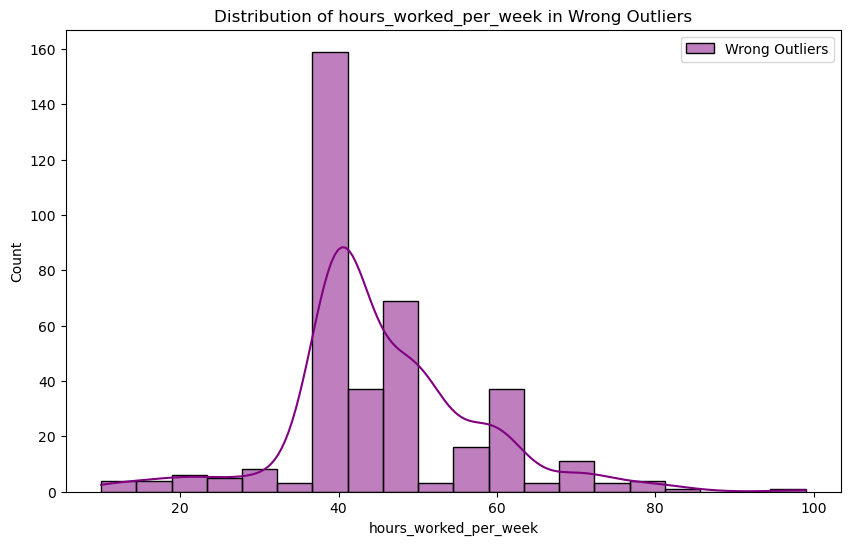

In [26]:
# 잘못 예측된 데이터에서 이상치 데이터 분포
wrong_outliers_data = wrong_outliers[wrong_outliers['is_outlier']]

# 주요 변수의 분포
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    sns.histplot(wrong_outliers_data[col], kde=True, color='purple', bins=20, label='Wrong Outliers')
    plt.title(f'Distribution of {col} in Wrong Outliers')
    plt.legend()
    plt.show()


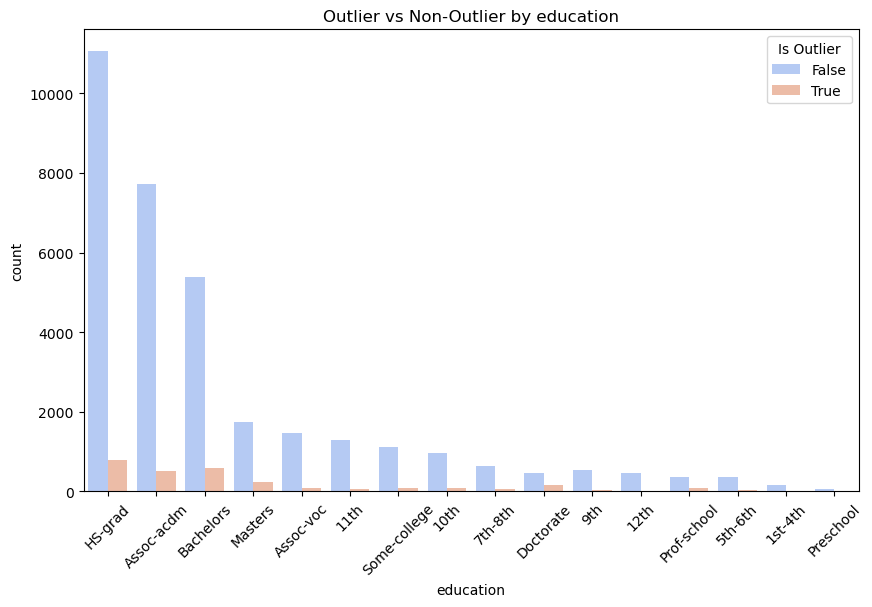

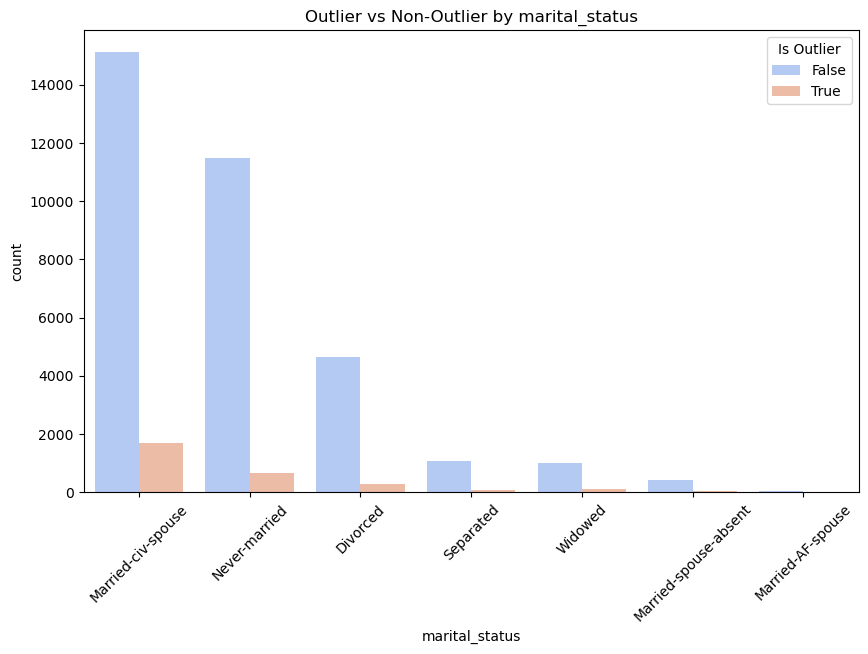

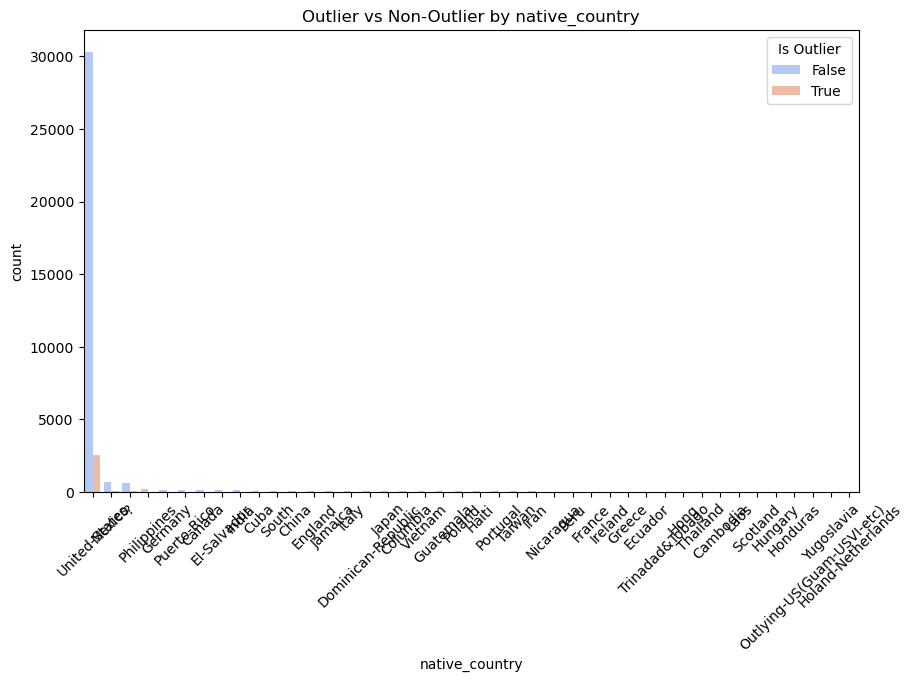

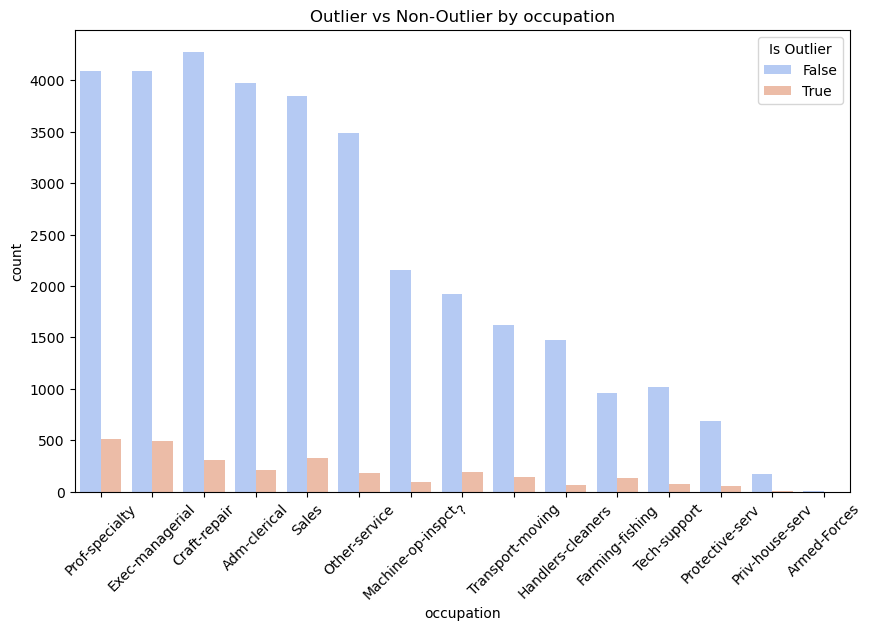

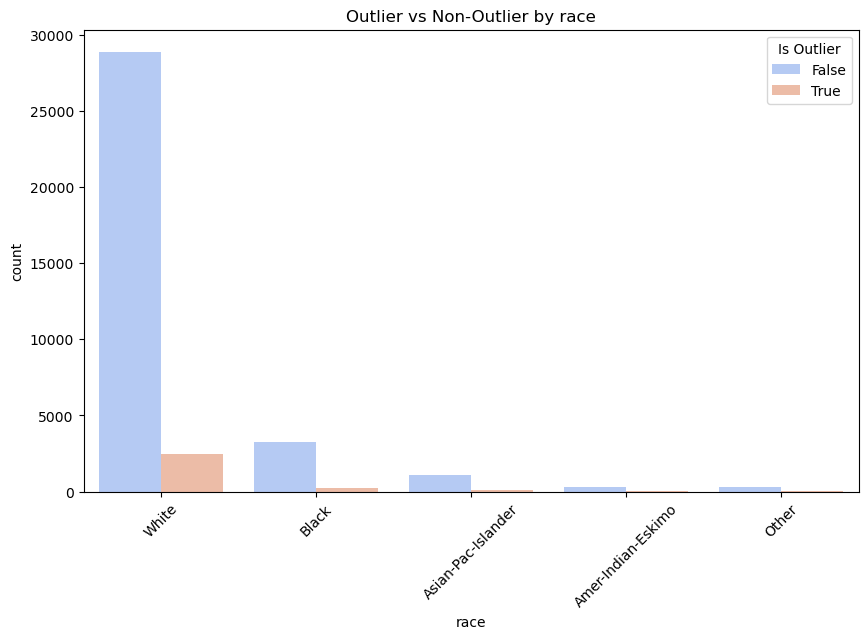

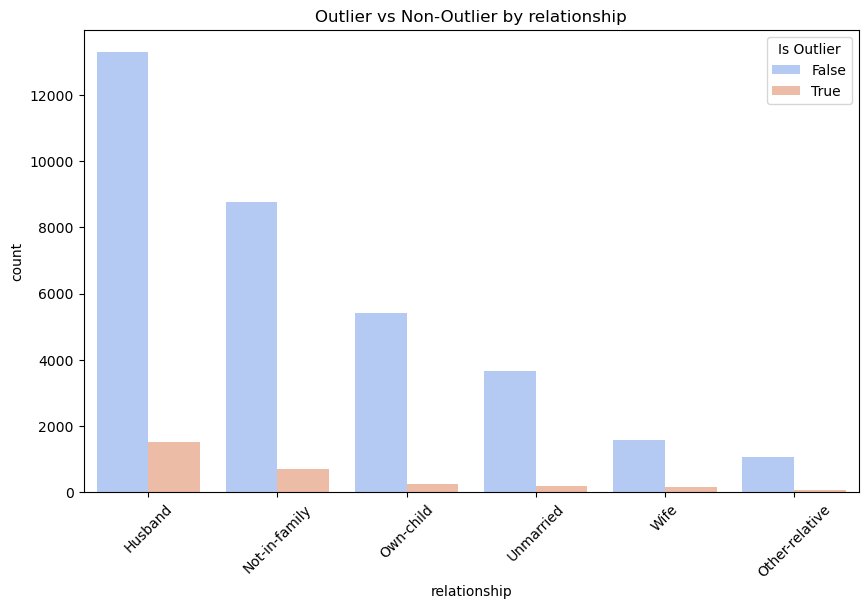

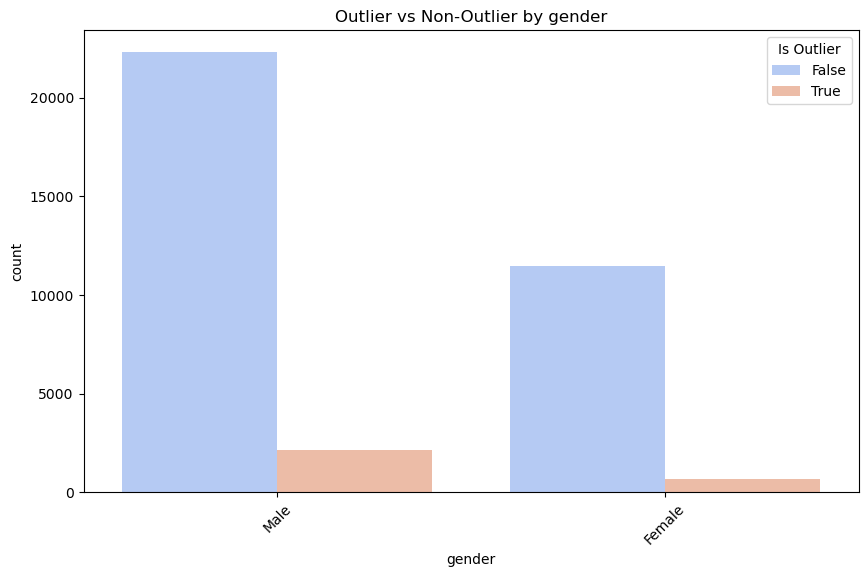

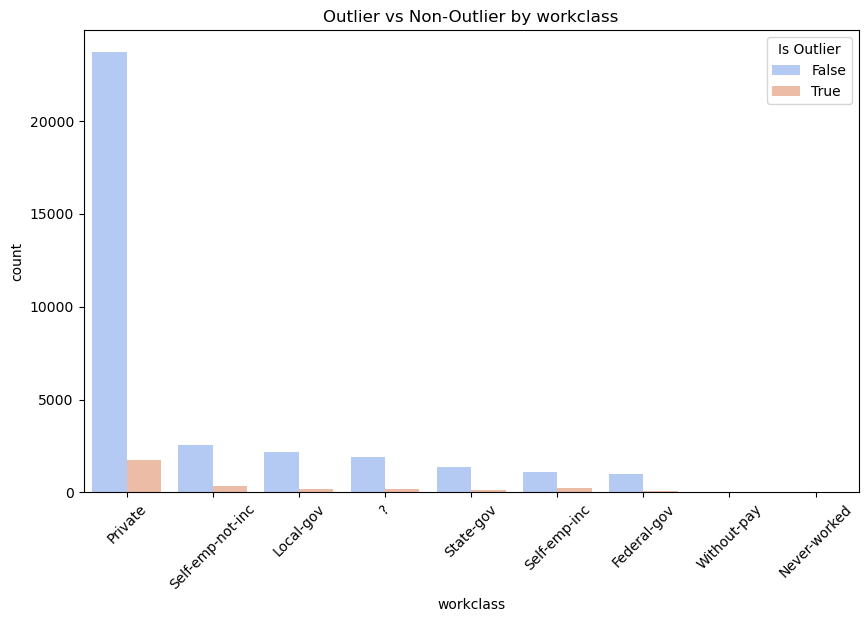

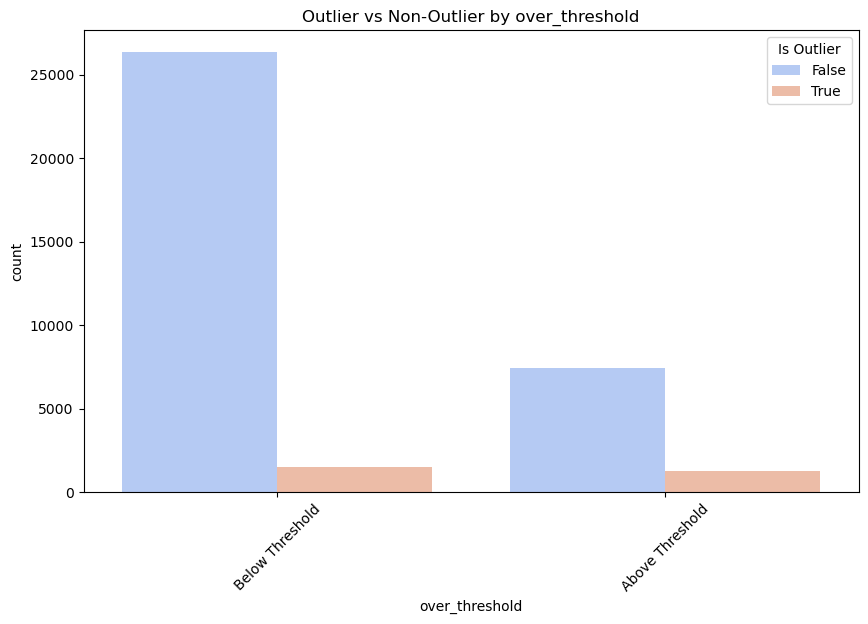

In [27]:
# 범주형 변수와 이상치 관계
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    
    sns.countplot(x=col, data=df, hue='is_outlier', palette='coolwarm', order=df[col].value_counts().index)
    plt.title(f'Outlier vs Non-Outlier by {col}')
    plt.legend(title='Is Outlier')
    plt.xticks(rotation=45)
    plt.show()


### Fair metric

In [28]:
# prediction 열 추가
df['prediction'] = df['over_threshold']  # 초기화 (정답과 동일)
df.loc[df_wrong.index, 'prediction'] = df_wrong['prediction']  # 잘못된 예측 데이터 반영

# 확인
print(df[['over_threshold', 'prediction']].head())


    over_threshold       prediction
0  Below Threshold  Below Threshold
1  Below Threshold  Below Threshold
2  Below Threshold  Below Threshold
3  Below Threshold  Below Threshold
4  Below Threshold  Below Threshold


Confusion Matrix:
Predicted        Above Threshold  Below Threshold
Actual                                           
Above Threshold             7838              927
Below Threshold              821            27045


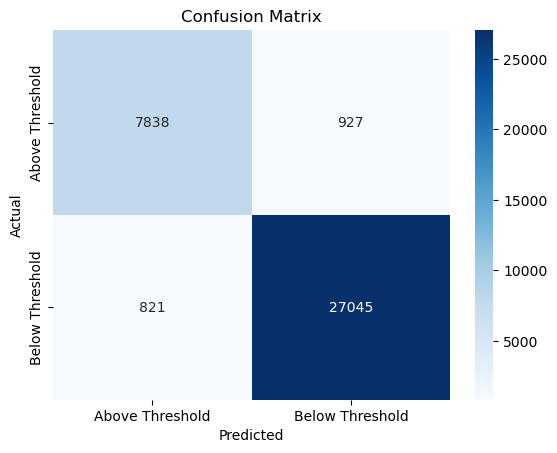

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 데이터에서 Confusion Matrix 계산
confusion_matrix = pd.crosstab(df['over_threshold'], df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Confusion Matrix 출력
print("Confusion Matrix:")
print(confusion_matrix)

# Confusion Matrix 시각화
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [30]:
# TP, TN, FP, FN 계산
tp = confusion_matrix.loc['Above Threshold', 'Above Threshold']
tn = confusion_matrix.loc['Below Threshold', 'Below Threshold']
fp = confusion_matrix.loc['Below Threshold', 'Above Threshold']
fn = confusion_matrix.loc['Above Threshold', 'Below Threshold']

print(f"True Positive (TP): {tp}")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")


True Positive (TP): 7838
True Negative (TN): 27045
False Positive (FP): 821
False Negative (FN): 927


In [31]:
# Gender별 Recall 계산
gender_groups = df.groupby('gender')

for gender, group in gender_groups:
    tp_gender = group[(group['over_threshold'] == 'Above Threshold') & (group['prediction'] == 'Above Threshold')].shape[0]
    fn_gender = group[(group['over_threshold'] == 'Above Threshold') & (group['prediction'] == 'Below Threshold')].shape[0]
    
    recall_gender = tp_gender / (tp_gender + fn_gender) if (tp_gender + fn_gender) > 0 else 0
    print(f"Equality of Opportunity (Recall) for {gender}: {recall_gender:.2%}")


Equality of Opportunity (Recall) for Female: 88.19%
Equality of Opportunity (Recall) for Male: 89.65%


Confusion Matrix for Female:
Predicted        Above Threshold  Below Threshold
Actual                                           
Above Threshold             1187              159
Below Threshold              322            10496


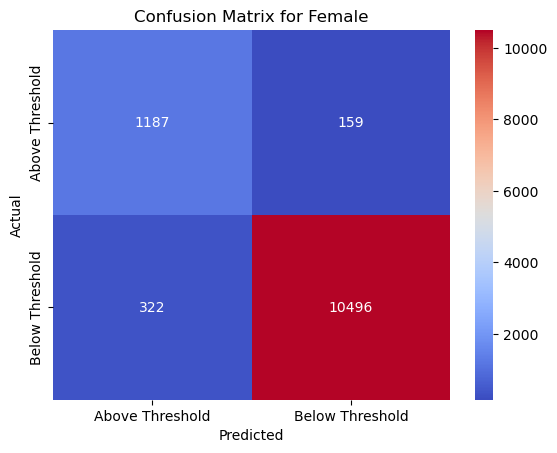

Confusion Matrix for Male:
Predicted        Above Threshold  Below Threshold
Actual                                           
Above Threshold             6651              768
Below Threshold              499            16549


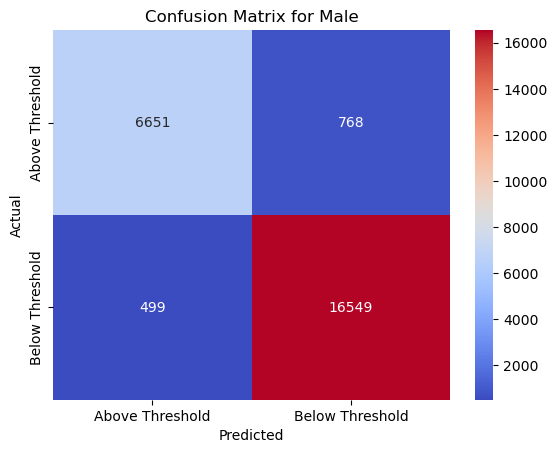

In [32]:
# Gender별 Confusion Matrix 시각화
for gender, group in gender_groups:
    confusion_matrix_gender = pd.crosstab(group['over_threshold'], group['prediction'], rownames=['Actual'], colnames=['Predicted'])
    
    print(f"Confusion Matrix for {gender}:")
    print(confusion_matrix_gender)
    
    sns.heatmap(confusion_matrix_gender, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Confusion Matrix for {gender}")
    plt.show()


In [33]:
# 성별별 False Negative 추출
fn_data = df_wrong[(df_wrong['over_threshold'] == 'Above Threshold') & (df_wrong['prediction'] == 'Below Threshold')]

# 성별별 FN 비율 확인
gender_fn = fn_data['gender'].value_counts(normalize=True)
print("Gender-wise FN Proportion:")
print(gender_fn)

# 성별별 Recall 차이 확인
gender_groups = df.groupby('gender')
for gender, group in gender_groups:
    tp_gender = group[(group['over_threshold'] == 'Above Threshold') & (group['prediction'] == 'Above Threshold')].shape[0]
    fn_gender = group[(group['over_threshold'] == 'Above Threshold') & (group['prediction'] == 'Below Threshold')].shape[0]
    
    recall_gender = tp_gender / (tp_gender + fn_gender) if (tp_gender + fn_gender) > 0 else 0
    print(f"Recall for {gender}: {recall_gender:.2%}")


Gender-wise FN Proportion:
gender
Male      0.809387
Female    0.190613
Name: proportion, dtype: float64
Recall for Female: 88.19%
Recall for Male: 89.65%


In [34]:
# FN 데이터 추출
fn_data = df_wrong[(df_wrong['over_threshold'] == 'Above Threshold') & (df_wrong['prediction'] == 'Below Threshold')]

# 성별별 FN 데이터 분포 확인
print(fn_data['gender'].value_counts())

# FN 데이터 비율에 따라 학습할 데이터 선정
# 성별 비율 균형 맞추기
balanced_fn_data = fn_data.groupby('gender', group_keys=False).apply(lambda x: x.sample(n=min(fn_data['gender'].value_counts())))
print("Balanced FN Data:", len(balanced_fn_data))
print(balanced_fn_data)


gender
Male      3104
Female     731
Name: count, dtype: int64
Balanced FN Data: 1462
      age  capital_gain  capital_loss   education  final_weight  \
3528   40             0             0     Masters        270147   
2981   45             0             0   Bachelors        306122   
1731   30             0             0   Bachelors        100734   
2354   44             0             0     HS-grad        408531   
4751   39             0             0  Assoc-acdm        380614   
...   ...           ...           ...         ...           ...   
2090   66             0             0   Bachelors        104576   
4457   28             0             0   Bachelors        134813   
2153   46             0             0     HS-grad        224559   
2563   48             0             0  Assoc-acdm        350440   
1963   46             0             0     HS-grad         84790   

      hours_worked_per_week      marital_status native_country  \
3528                     40       Never-mar

/tmp/ipykernel_2528521/1541290121.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_fn_data = fn_data.groupby('gender', group_keys=False).apply(lambda x: x.sample(n=min(fn_data['gender'].value_counts())))


In [35]:
# FN 데이터에서 이상치 비율 확인
from scipy.stats import zscore

numeric_cols = df.select_dtypes(include='number').columns
fn_data['is_outlier'] = fn_data[numeric_cols].apply(zscore).abs().max(axis=1) > 3

# FN 데이터 내 이상치 비율
outlier_ratio = fn_data['is_outlier'].mean()
print(f"Proportion of outliers in FN data: {outlier_ratio:.2%}")

# 이상치 제거 후 데이터 확인
fn_data_no_outliers = fn_data[~fn_data['is_outlier']]
print("FN data without outliers:")
print(fn_data_no_outliers)


Proportion of outliers in FN data: 8.50%
FN data without outliers:
      age  capital_gain  capital_loss    education  final_weight  \
0      32             0             0  Prof-school        303692   
1      29             0             0      HS-grad        229124   
2      37             0             0    Bachelors        355856   
3      40             0             0   Assoc-acdm         34178   
4      37             0             0      HS-grad         32528   
...   ...           ...           ...          ...           ...   
4934   42             0             0      HS-grad        107563   
4935   28             0             0         11th        410216   
4936   48             0             0    Bachelors        198000   
4939   30             0             0   Assoc-acdm        176185   
4940   49             0             0    Assoc-voc        156926   

      hours_worked_per_week         marital_status native_country  \
0                        40               Divor

/tmp/ipykernel_2528521/1919381176.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_data['is_outlier'] = fn_data[numeric_cols].apply(zscore).abs().max(axis=1) > 3


In [36]:
# 성별별 False Negative 추출
fn_data = fn_data_no_outliers[(fn_data_no_outliers['over_threshold'] == 'Above Threshold') & (fn_data_no_outliers['prediction'] == 'Below Threshold')]

# 성별별 FN 비율 확인
gender_fn = fn_data['gender'].value_counts(normalize=True)
print("Gender-wise FN Proportion:")
print(gender_fn)


Gender-wise FN Proportion:
gender
Male      0.815047
Female    0.184953
Name: proportion, dtype: float64
